# Figures for Frame et al. 2022 "On mass conservation..."

# WARNING: Make sure to run the following scripts first, as figures here rely on those statistics 
* `make_tables.ipynb` 
* `calculate_mass_balance.py`

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
import metrics
import random
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st

In [2]:
#Utility function to create a matplotlib figure with cm sizes

def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [3]:
xr.__version__

'0.16.1'

In [4]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [5]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [6]:
# Get the hydrologic units for each basin.
with open('../data/usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in pd_attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
pd_attributes['basin_hydro_unit'] = basin_hydro_unit
huc_regions = set(list(pd_attributes['basin_hydro_unit']))

In [7]:
basin_plot_unit = []
for b in pd_attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    if int(hu[0:2]) < 4:
        basin_plot_unit.append('east')
    elif int(hu[0:2]) < 13:
        basin_plot_unit.append('central')
    else:
        basin_plot_unit.append('west')
pd_attributes['basin_plot_unit'] = basin_plot_unit
plot_units = set(list(pd_attributes['basin_plot_unit']))

In [8]:
forcing_products = ['nldas', 'daymet']
time_splitz = ['time_split1','time_split2']
error_typez = ['absolute', 'positive', 'negative']
time_split_numbers = [1,2]

In [9]:
analysis_dict_all={forcing_type:{} for forcing_type in forcing_products}
peak_flows_dict={forcing_type:{} for forcing_type in forcing_products}
for forcing_type in forcing_products:
    for its, time_split in enumerate(time_splitz):
        #-------------------------------------------------------------------------------------------------
        frequency_analysis_dict = 'frequency_analysis_dict_{}_{}.pkl'.format(time_split, forcing_type)
        #peak_annual_flows_dict = 'peak_annual_flows_dict_{}_{}.pkl'.format(time_split, forcing_type)
        #-------------------------------------------------------------------------------------------------

        print('    opening ', frequency_analysis_dict)
        with open(frequency_analysis_dict, 'rb') as fb:
            analysis_dict_all[forcing_type][time_split] = pkl.load(fb)


    opening  frequency_analysis_dict_time_split1_nldas.pkl
    opening  frequency_analysis_dict_time_split2_nldas.pkl
    opening  frequency_analysis_dict_time_split1_daymet.pkl
    opening  frequency_analysis_dict_time_split2_daymet.pkl


In [10]:
basin_list={forcing:{} for forcing in forcing_products}
for forcing_type in forcing_products:
    for its, time_split in enumerate(time_splitz):
        basin_list[forcing_type][time_split] = list(analysis_dict_all[forcing_type][time_split].keys())

In [11]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
def get_models_flows(forcing_type, time_split='time_split2'):
    if time_split == 'time_split1':
        return (['lstm', 'mc', 'sac'], ['lstm', 'mc', 'sac', 'obs'])
    if forcing_type == 'daymet':
        return (['lstm', 'mc', 'sac'], ['lstm', 'mc', 'sac', 'obs'])
    else:
        return (['lstm', 'mc', 'sac','nwm'], ['lstm', 'mc', 'sac', 'nwm', 'obs'])
                
#-------------------------------------------------------------------------------------------------

all_metrics = ['NSE','MSE','RMSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing',
               'beta-abs', 'peakQ', 'peakRI', 'peakT', 'peakQ-perc', 'peakRI-perc', 'peakT-abs']

In [12]:
analysis_dict={forcing_type:{} for forcing_type in forcing_products}

for forcing_type in forcing_products:
    for time_split in time_splitz:
        
        models, flows = get_models_flows(forcing_type, time_split)
        
        analysis_dict[forcing_type][time_split] = \
            {metric:{model:[] for model in models} for metric in all_metrics}

        for ib, basin_0str in enumerate(basin_list[forcing_type][time_split]):
            for metric in all_metrics:
                for model in models:
                    analysis_dict[forcing_type][time_split][metric][model].extend( \
                        analysis_dict_all[forcing_type][time_split][basin_0str][metric][model])
                                

In [13]:
print(analysis_dict_all[forcing_type][time_split]['10244950']['NSE'])

{'nwm': [-8.781911949284813, -0.0639989883085248, -1.9530710391408705, 0.1529024537138156, -10.572555974726725, -4.582376664348561, -48.5421518818546, -1.5703456597467307, -38.26434844837424, 0.0006793275502744445, -2.2813674615523922, -21.228042255639807, -15.84898434033716, 0.6212925831640699, 0.20786131496370275, -0.34981589983698, -1.738945894561442, -9.035045629802724], 'lstm': [-0.29733967781066895, -0.32970499992370605, 0.8364249616861343, 0.841456413269043, 0.06695908308029175, 0.7235347032546997, 0.07624483108520508, 0.14780592918395996, 0.028156757354736328, 0.9597493894398212, -0.21456408500671387, -1.0946433544158936, -0.9868775606155396, 0.056939780712127686, 0.6232613623142242, 0.7935289740562439, 0.23001927137374878, -2.4729084968566895], 'mc': [-1.4311487674713135, 0.42390352487564087, 0.8625120967626572, 0.5862612128257751, -1.8810923099517822, -3.7920784950256348, -2.337017297744751, 0.6130432486534119, -1.4240288734436035, 0.6262185871601105, 0.19962990283966064, -2.

In [14]:
forcing_type='nldas'
time_split='time_split1'
metric_dfs = {}
for metric in all_metrics:
    metric_dfs[metric] = pd.DataFrame(columns=["lstm", "mclstm","sac"], 
                                      index=basin_list[forcing_type][time_split])
    for ib, basin_0str in enumerate(basin_list[forcing_type][time_split]):
        df = pd.DataFrame(analysis_dict_all[forcing_type][time_split])
        metric_dfs[metric].loc[basin_0str, ] = analysis_dict_all[forcing_type][time_split]

        break

In [15]:
ylimz_bar = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,0.7], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
ylimz_box = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,1], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
xlimz_freq = {'NSE':[-1,1], 'MSE':[0,1], 'RMSE':[0,0.7], 'KGE':[-1,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.4,0.1], 'FHV':[-60,60], 'FMS':[0,-60],'FLV':[-25,25], 'Peak-Timing':[-1,1],
          'beta-abs':[0,0.4], 'peakQ':[-20000, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,2], 'peakRI-perc':[0,1.3], 'peakT-abs':[0,2.2]}
namz = {'NSE':'Nash–Sutcliffe efficiency', 'MSE':'Mean squared error', 'RMSE':'Root mean squared error', 
        'KGE':'Kling-Gupta efficiency', 'Alpha-NSE':'Alpha-NSE: Flow variance', 'Pearson-r':'Pearson-r', 
         'Beta-NSE':'Beta-NSE: Volume bias', 'FHV':'FHV: Top 2 % peak flow bias', 
         'FMS':'FMS: Bias of FDC midsegment slope','FLV':'FLV: 30 % low flow bias', 
         'Peak-Timing':'Peak-Timing error','beta-abs':'Absolute volume bias', 'peakQ':'Peak flow error', 
         'peakRI':'Peak recurrence interval error', 'peakT':'Timing error of peak flow', 
         'peakQ-perc':'Abs. percent error of peak flow', 'peakRI-perc':'Abs. percent error of recurrence', 
         'peakT-abs':'Absolute timing error of peak flow'}
legend_locz = {'NSE':'upper right', 'MSE':'upper left', 'RMSE':'upper left', 
        'KGE':'upper right', 'Alpha-NSE':'lower right', 'Pearson-r':'lower right', 
         'Beta-NSE':'lower left', 'FHV':'lower left', 'FMS':'lower right','FLV':'upper right', 
         'Peak-Timing':'upper right','beta-abs':'upper right', 'peakQ':'lower left', 
         'peakRI':'lower left', 'peakT':'lower left', 
         'peakQ-perc':'upper left', 'peakRI-perc':'upper left', 'peakT-abs':'upper center'}
colz = {'NSE':2, 'MSE':1, 'RMSE':1, 'KGE':2, 'Alpha-NSE':2, 'Pearson-r':1, 
         'Beta-NSE':1, 'FHV':1, 'FMS':1,'FLV':2, 'Peak-Timing':1,
          'beta-abs':2, 'peakQ':1, 'peakRI':1, 'peakT':1, 
          'peakQ-perc':1, 'peakRI-perc':1, 'peakT-abs':1}

In [16]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_colors = ['b', 'orange', 'red', 'red']
model_style = ['-', '-', '-', '--']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}

base_metrics = metrics.get_available_metrics()

In [17]:
plot_metrics = ['NSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing']
ppm = {'NSE':'NSE','KGE':'KGE','Alpha-NSE':'Alpha-NSE',
       'Pearson-r':'Pearson-r','Beta-NSE':'Beta-NSE',
       'FHV':'FHV','FMS':'FMS','FLV':'FLV','peakT-abs':'Peak-Timing'}

In [18]:
def set_box_color(bp, color, linestylez='-', linewidthz=2):
    plt.setp(bp['boxes'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['whiskers'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['caps'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['medians'], color=color, linestyle=linestylez,linewidth=linewidthz)

In [19]:
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb:
    nwm_results = pkl.load(fb)
    
lstm_results_time_split2 = {}
mclstm_results_time_split2 = {}
sacsma_results_time_split2 = {}
with open('./model_output_for_analysis/lstm_time_split2_nldas.p', 'rb') as fb:
    lstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split2_nldas.p', 'rb') as fb:
    mclstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split2_nldas.p', 'rb') as fb:
    sacsma_results_time_split2 = pkl.load(fb)
    
lstm_results_time_split1 = {}
mclstm_results_time_split1 = {}
sacsma_results_time_split1 = {}
with open('./model_output_for_analysis/lstm_time_split1_nldas_ens.p', 'rb') as fb:
    lstm_results_time_split1 = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split1_nldas_ens.p', 'rb') as fb:
    mclstm_results_time_split1 = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split1_nldas_ens.p', 'rb') as fb:
    sacsma_results_time_split1 = pkl.load(fb)

In [20]:
labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
forcingz={'nldas':'NLDAS', 'daymet':'Daymet'}

In [21]:

start_date1 = pd.Timestamp('1989-10-01')
end_date1 = pd.Timestamp('1999-01-01')
start_date2 = pd.Timestamp('1996-10-01')
end_date2 = pd.Timestamp('2014-01-01')

with open('total_mass_error_ens.pkl', 'rb') as fb:
    total_mass_error = pkl.load(fb)
with open('total_mass_ens.pkl', 'rb') as fb:
    total_mass = pkl.load(fb)
with open('cumulative_mass_all_ens.pkl', 'rb') as fb: 
    cumulative_mass_all = pkl.load(fb)


In [22]:
total_mass_error_dict = {forcing_type:{tsplt:{error_type:{} for \
                         error_type in error_typez} for \
                         tsplt in time_splitz} for \
                         forcing_type in forcing_products}

In [23]:
total_mass_error['nldas']['time_split2']['absolute'].keys()

dict_keys(['lstm', 'mc', 'sac', 'obs', 'nwm'])

In [24]:
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

time split time_split1
forcing type nldas
time split time_split1
forcing type daymet


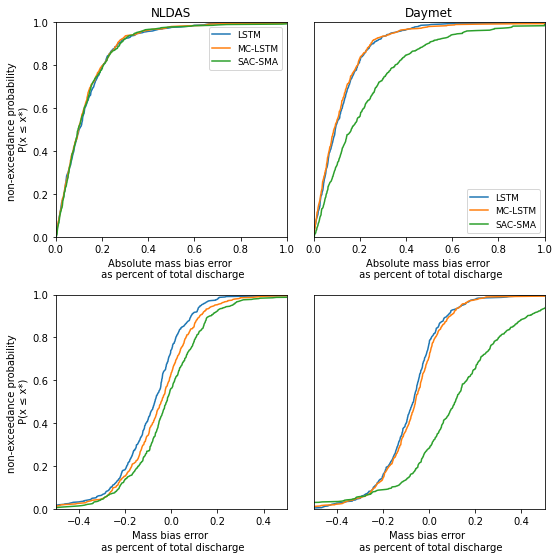

time split time_split2
forcing type nldas
time split time_split2
forcing type daymet


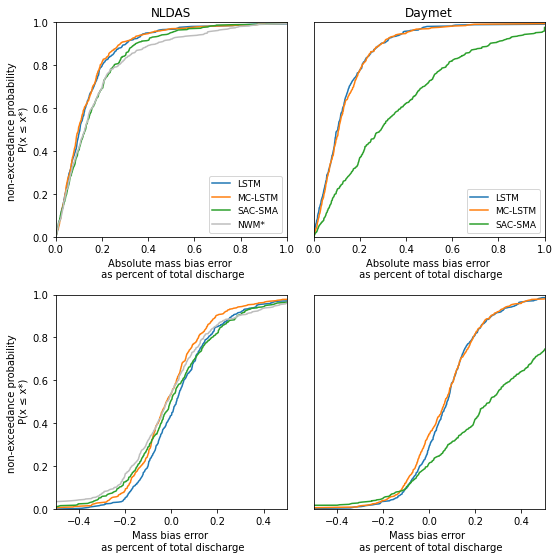

In [25]:

for tsplt in time_splitz:

    fig = plt.figure(figsize=cm2inch(20,20))
    plot_here=1

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)
        
        print('time split', tsplt)
        print('forcing type', forcing_type)

        limz = {'absolute':([0,1],[0,1]), 'positive':([0,1],[0.4,1]), 
                'negative':([-1,0],[0,0.4]), 'neg-pos':([-.5,.5],[0,1])}
        xlabz = {'absolute':'Absolute mass bias error \n as percent of total discharge', 
                 'positive':'Positive mass error (percent)', 
                 'negative':'Negative mass error (percent)',
                 'neg-pos':'Mass bias error \n as percent of total discharge'}
        yvalues={}
        plotdata={}
        for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):

            plot_dict = {model:total_mass_error[forcing_type][tsplt][error_type][model] for \
                                    model in models}
            plot_df = pd.DataFrame(plot_dict)
            plot_df = plot_df.loc[:,models]
            df_labz = [labelz[model] for model in plot_df.columns.values]
            plotdata[error_type] = np.sort(plot_df[~pd.isnull(plot_df)], axis=0)


        # ---------------------------------------------------------------------------------
        error_type = 'absolute'
        for model in models:
            yvalues[model] = list(range(len(total_mass_error[forcing_type][tsplt][error_type][model])))
            for i, _ in enumerate(yvalues[model]):
                yvalues[model][i] = yvalues[model][i]/len(yvalues[model])        

        if forcing_type == 'nldas':
            plot_here = 1
        elif forcing_type == 'daymet':
            plot_here = 2

        ax = fig.add_subplot(2, 2, plot_here)

        if forcing_type == 'nldas':
            ax.set_prop_cycle(color=colz)
        elif forcing_type == 'daymet':
            ax.set_prop_cycle(color=colz[:-1])

        df_plot = pd.DataFrame(data=plotdata[error_type], columns=df_labz)
        ax.plot(df_plot, yvalues[model][:len(plotdata[error_type])])
        
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_title(forcingz[forcing_type])
        ax.legend(df_labz, fontsize=9)
        ax.set_xlabel(xlabz['absolute'])
        if forcing_type == 'daymet':
            ax.set_yticks([])
        else:
            ax.set_ylabel("non-exceedance probability \n P(x ≤ x*)")
        # ---------------------------------------------------------------------------------


        # ---------------------------------------------------------------------------------  
        error_type = 'neg-pos'
        if forcing_type == 'nldas':
            plot_here = 3
        elif forcing_type == 'daymet':
            plot_here = 4
        plotdata['neg-pos'] = np.zeros(plotdata['negative'].shape)
        iloc=0
        for j, k in zip(plotdata['negative'], plotdata['positive']):
            for a in range(plotdata['negative'].shape[1]):
                if np.abs(j[a]) > np.abs(k[a]):
                    plotdata['neg-pos'][iloc,a] = j[a]
                else:
                    plotdata['neg-pos'][iloc,a] = k[a]
            iloc+=1
        ax = fig.add_subplot(2, 2, plot_here)

        if forcing_type == 'nldas':
            ax.set_prop_cycle(color=colz)
        elif forcing_type == 'daymet':
            ax.set_prop_cycle(color=colz[:-1])

        df_plot = pd.DataFrame(data=plotdata['neg-pos'], columns=df_labz)
        ax.plot(df_plot, yvalues[model][:len(plotdata[error_type])])
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_xlabel(xlabz[error_type])
        if forcing_type == 'daymet':
            ax.set_yticks([])
        else:
            ax.set_ylabel("non-exceedance probability \n P(x ≤ x*)")
        # ---------------------------------------------------------------------------------


    fig.tight_layout()
#     fig.savefig('../figs/mass_error_frequencies_{}.eps'.format(tsplt), dpi=600, format="eps")
#     fig.savefig('../figs/mass_error_frequencies_{}.png'.format(tsplt), dpi=600)
    plt.show()
    plt.close()

In [26]:
with open('mass_basin_list.pkl', 'rb') as fb:
    mass_basin_list = pkl.load(fb)
mass_basin_list_int = {'time_split1':[int(i) for i in mass_basin_list['time_split1']],
                       'time_split2':[int(i) for i in mass_basin_list['time_split2']]}

In [27]:
mass_error_list_for_plot={}
for tsplt in time_splitz:
    
    models, flows = get_models_flows('daymet')
    mass_error_list_for_plot[tsplt] = {forcing_type:{model:[] for model in models} for \
                                       forcing_type in forcing_products}

    if tsplt == 'time_split2':
        mass_error_list_for_plot[tsplt]['nldas']['nwm']=[]
    
    for forcing_type in forcing_products:
    
        models, flows = get_models_flows(forcing_type, tsplt)
        
        print('time split', tsplt)
        print('forcing type', forcing_type)
        print('models', models)
        
        for imod, model in enumerate(models):

            count_loop = 0

            for i, j in zip(total_mass_error[forcing_type][tsplt]['positive'][model], 
                            total_mass_error[forcing_type][tsplt]['negative'][model]):
                if forcing_type == 'Daymet' and model == 'nwm':
                    continue
                elif np.abs(i) > np.abs(j):
                    mass_error_list_for_plot[tsplt][forcing_type][model].append(i)
                elif np.abs(i) < np.abs(j):
                    mass_error_list_for_plot[tsplt][forcing_type][model].append(j)
                else:
                    print('same?')
                count_loop += 1
            print(count_loop)

time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
530
530
530
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
530
530
530
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
484
484
484
484
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
484
484
484


time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']


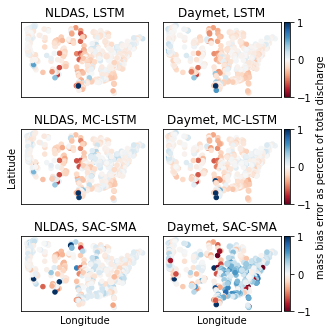

time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']


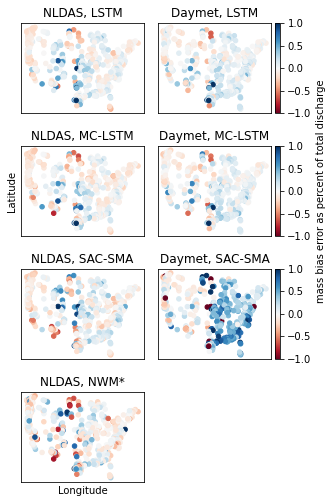

In [28]:

for tsplt in time_splitz:

    if tsplt == 'time_split1':
        fig = plt.figure(figsize=cm2inch(12,12))
    if tsplt == 'time_split2':
        fig = plt.figure(figsize=cm2inch(12,18))
    plot_here=1

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)

        for model in models:
            
            print('time split', tsplt)
            print('forcing type', forcing_type)
            print('models', models)

            if forcing_type == 'daymet' and model == 'nwm':
                continue

            if forcing_type == 'nldas' and model == 'lstm':
                plot_here = 1
            if forcing_type == 'daymet' and model == 'lstm':
                plot_here = 2
            if forcing_type == 'nldas' and model == 'mc':
                plot_here = 3
            if forcing_type == 'daymet' and model == 'mc':
                plot_here = 4
            if forcing_type == 'nldas' and model == 'sac':
                plot_here = 5
            if forcing_type == 'daymet' and model == 'sac':
                plot_here = 6

            if tsplt == 'time_split2':
                if forcing_type == 'nldas' and model == 'nwm':
                    plot_here = 7
                    
            if tsplt == 'time_split2':
                ax = fig.add_subplot(4, 2, plot_here)
            if tsplt == 'time_split1':
                ax = fig.add_subplot(3, 2, plot_here)
                
            im = ax.scatter(pd_attributes.loc[mass_basin_list_int[tsplt], 'gauge_lon'].values, 
                             pd_attributes.loc[mass_basin_list_int[tsplt], 'gauge_lat'].values,
                            c=mass_error_list_for_plot[tsplt][forcing_type][model],
                            s=20,
                            cmap='RdBu',
                            vmin=-1, 
                            vmax=1)
            ax.set_title(str(forcingz[forcing_type])+', '+str(labelz[model]))

            if model=="sac" and tsplt == 'time_split1' or model=="nwm" and tsplt == 'time_split2' :
                ax.set_xlabel("Longitude")
            if model=="mc" and forcing_type=="nldas":
                ax.set_ylabel("Latitude")
    
            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

            clims = im.get_clim()


            # colorbar
            if plot_here in [2,4,6]:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(im, cax=cax, orientation='vertical')
            if plot_here in [4]:
                cbar.set_label('mass bias error as percent of total discharge', rotation=90)

            plot_here+=1

    plt.tight_layout()
    plt.show()
#     fig.savefig('../figs/mass_bias_mapzz_{}.eps'.format(tsplt), dpi=600, format="eps")
#     fig.savefig('../figs/mass_bias_mapzz_{}.png'.format(tsplt), dpi=600)
    plt.close()

In [29]:
mass_error_types = ['positive', 'negative', 'absolute']

In [30]:
usgs_wrregions_list = ['N.E.','Mid-Atl.','S. Atl.-Gulf','Grt. Lakes','Ohio',
                      'Tennessee','Up. Miss.','Low. Miss.','Souris-Rd',
                      'Missouri','Ark-Wt-Rd','TX-Gulf','Rio Grnd.','Upper Col.',
                      'Lower Col.','Grt. Basin','Pac. NW','California']
usgs_wrregions_lookup = {str(x+1).zfill(2):usgs_wrregions_list[x] for x in range(len(usgs_wrregions_list))}

# Not enout data to get statistics
usgs_wrregions_list.remove('Souris-Rd')

plot_regions = ['west', 'central', 'east']
usgs_wrregions_list_without_Souris = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18]

absolute
time split time_split1
forcing type nldas
['lstm', 'mc', 'sac']


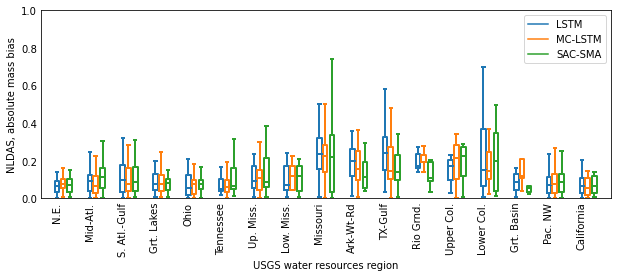

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.066945  0.080534  0.072458
1   0.093822  0.077681  0.116192
2   0.113058  0.105155  0.113154
3   0.090024  0.089017  0.085726
4   0.072773  0.080584  0.081980
5   0.081381  0.075053  0.104166
6   0.121498  0.135157  0.137645
7   0.105925  0.116224  0.108444
8   0.256266  0.244757  0.246342
9   0.200663  0.184325  0.140580
10  0.300820  0.246130  0.169084
11  0.196538  0.207824  0.131806
12  0.170510  0.210862  0.195058
13  0.231825  0.233437  0.292080
14  0.085656  0.183829  0.111272
15  0.078932  0.089157  0.096375
16  0.095174  0.082809  0.166269
lstm    0.138930
mc      0.143678
sac     0.139331
dtype: float64
absolute
time split time_split1
forcing type daymet
['lstm', 'mc', 'sac']


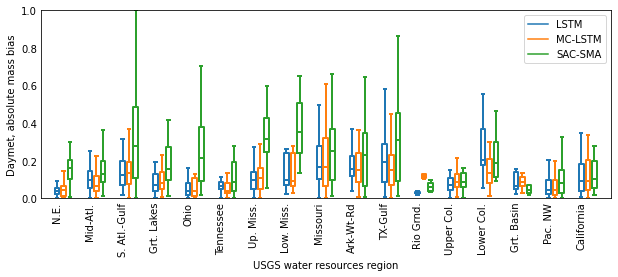

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.041800  0.048419  0.149552
1   0.106002  0.082688  0.156757
2   0.141660  0.141559  0.327103
3   0.089719  0.096387  0.177720
4   0.055103  0.062293  0.241006
5   0.076943  0.058983  0.146213
6   0.102852  0.111041  0.336553
7   0.142582  0.144076  0.374979
8   0.201779  0.201193  0.349497
9   0.178135  0.180126  0.237553
10  0.292858  0.297039  0.319011
11  0.033039  0.119830  0.119121
12  0.100180  0.127372  0.101670
13  0.282180  0.204817  0.237358
14  0.088579  0.085579  0.088960
15  0.068759  0.068273  0.117843
16  0.115194  0.123184  0.170216
lstm    0.124551
mc      0.126639
sac     0.214771
dtype: float64
absolute
time split time_split2
forcing type nldas
['lstm', 'mc', 'sac', 'nwm']


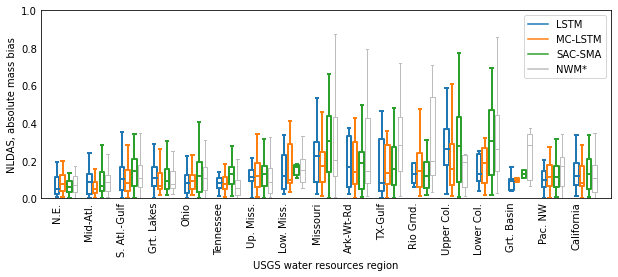

['lstm', 'mc', 'sac', 'nwm']
        lstm        mc       sac       nwm
0   0.068763  0.089123  0.061489  0.094590
1   0.084625  0.063811  0.096002  0.105660
2   0.114173  0.098214  0.149286  0.135666
3   0.124826  0.104893  0.129479  0.120205
4   0.081741  0.103354  0.122955  0.110186
5   0.079786  0.080780  0.135741  0.064509
6   0.120602  0.135369  0.128055  0.112387
7   0.147661  0.182745  0.182206  0.162747
8   0.223627  0.192813  0.319121  0.301488
9   0.241510  0.208868  0.223384  0.262601
10  0.242939  0.249101  0.197460  0.669066
11  0.166231  0.176509  0.135162  0.324148
12  0.301503  0.204969  0.328661  0.243883
13  0.222798  0.245839  0.320577  0.340464
14  0.089631  0.134115  0.125222  0.232075
15  0.100621  0.124054  0.125193  0.176688
16  0.148132  0.137427  0.162433  0.165869
lstm    0.150539
mc      0.148940
sac     0.173084
nwm     0.213072
dtype: float64
absolute
time split time_split2
forcing type daymet
['lstm', 'mc', 'sac']


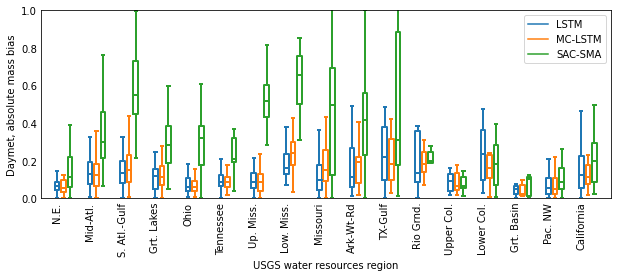

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.063827  0.063335  0.143521
1   0.139957  0.127825  0.345148
2   0.144659  0.159635  0.597048
3   0.119546  0.121754  0.301379
4   0.072159  0.070185  0.288967
5   0.100803  0.098333  0.242862
6   0.107063  0.109751  0.522918
7   0.189519  0.236723  0.619779
8   0.134461  0.186276  0.492961
9   0.181260  0.220875  0.442683
10  0.350241  0.261948  0.482409
11  0.202836  0.190804  0.193228
12  0.142744  0.151138  0.106442
13  0.233685  0.222699  0.184160
14  0.042959  0.043851  0.069596
15  0.070877  0.074803  0.136215
16  0.154069  0.148265  0.219270
lstm    0.144157
mc      0.146365
sac     0.316976
dtype: float64


In [31]:
plot_limz = {'absolute':[0,1], 'positive':[0,1], 'negative':[0,-1]}
for error_type in ['absolute']:
            
    for tsplt in time_splitz:

        for forcing in forcing_products:
        
            print(error_type)
            print('time split', tsplt)
            print('forcing type', forcing)

            models, flows = get_models_flows(forcing, tsplt)
            print(models)

            mass_bias_error_regional = {err_type:{forcing:pd.DataFrame(index=huc_regions, columns=models,
                data=np.zeros([len(huc_regions),len(models)])) for \
                forcing in forcing_products} for err_type in mass_error_types}

            mass_bias_error_dict = {err_type:{forcing:{model:{str(x).zfill(2):[] for \
                                              x in usgs_wrregions_list_without_Souris} for \
                                              model in models} for \
                                              forcing in forcing_products} for \
                                              err_type in mass_error_types}
            
            for ib, basin in enumerate(mass_basin_list[tsplt]):
                huc_id = pd_attributes.loc[int(basin), 'basin_hydro_unit']
                if huc_id == '09':
                    continue

                for model in models:

                    mass_bias_error_regional[error_type][forcing].loc[huc_id, model] += \
                        total_mass_error[forcing][tsplt][error_type][model][ib]

                    mass_bias_error_dict[error_type][forcing][model][huc_id].append(\
                        total_mass_error[forcing][tsplt][error_type][model][ib])
                    blanklab = ['' for x in usgs_wrregions_list]

                        
            width=0.14
            gapwidth=0.06

            df = mass_bias_error_regional[error_type][forcing].sort_index()
            df = df.rename(usgs_wrregions_lookup)

            fig = plt.figure(figsize=cm2inch(22,10))
            plt.ylabel(forcingz[forcing]+", "+error_type+" mass bias")
            plt.xlabel('USGS water resources region')

            x = np.arange(len(list(df.index.values))-1)
            if forcing == 'daymet':
                shift = [-(width+gapwidth), 0, (width+gapwidth)]
            elif forcing == 'nldas':
                shift = [-2*(width), -(3*width/4), (3*width/4), 2*(width)]

            data_to_plot={}
            bp={}
            data_to_plot['lstm'] = [mass_bias_error_dict[error_type][forcing]['lstm'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['lstm'] = plt.boxplot(data_to_plot['lstm'], positions=x + shift[0], 
                                sym='', widths=width, labels=usgs_wrregions_list)

            data_to_plot['mc'] = [mass_bias_error_dict[error_type][forcing]['mc'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['mc'] = plt.boxplot(data_to_plot['mc'], positions=x + shift[1] , sym='', widths=width, labels=blanklab)

            data_to_plot['sac'] = [mass_bias_error_dict[error_type][forcing]['sac'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['sac'] = plt.boxplot(data_to_plot['sac'], positions=x + shift[2], sym='', widths=width, labels=blanklab)

            set_box_color(bp['lstm'], '#1f77b4') # colors are from http://colorbrewer2.org/
            set_box_color(bp['mc'], '#ff7f0e')
            set_box_color(bp['sac'], '#2ca02c') # colors are from http://colorbrewer2.org/

            # draw temporary red and blue lines and use them to create a legend
            plt.plot([], c='#1f77b4', label='LSTM')
            plt.plot([], c='#ff7f0e', label='MC-LSTM')
            plt.plot([], c='#2ca02c', label='SAC-SMA')

            if forcing == 'nldas' and tsplt == 'time_split2':
                data_to_plot['nwm'] = [mass_bias_error_dict[error_type][forcing]['nwm'][str(x).zfill(2)] for \
                                          x in usgs_wrregions_list_without_Souris]
                bp['nwm'] = plt.boxplot(data_to_plot['nwm'], positions=x + shift[3], sym='', 
                                         widths=width, labels=blanklab)
                set_box_color(bp['nwm'], '#bdbdbd', linewidthz=1)
                plt.plot([], c='#bdbdbd', label='NWM*')

            plt.legend()

            plt.xticks(rotation=90)
            plt.tick_params(axis ='both', which ='both', length = 0)
            plt.ylim(plot_limz[error_type])
            plt.tight_layout()

            fig.tight_layout(pad=1.0)
            plt.show()
#            fig.savefig('../figs/massboxxs_{}_{}_{}.eps'.format(forcing, tsplt, error_type), dpi=600, format="eps")
#            fig.savefig('../figs/massboxxs_{}_{}_{}.png'.format(forcing, tsplt, error_type), dpi=600)
            plt.close()

    
            print(models)
            df_meanz = pd.DataFrame({model:[np.mean(data_to_plot[model][i]) for i in range(17)] for model in models})
            print(df_meanz)
            print(df_meanz.mean())
            
            

In [32]:
with open('statistics_table_st1.pkl', 'rb') as fb:
    st1_dict = pkl.load(fb)
with open('statistics_table_st2.pkl', 'rb') as fb:
    st2_dict = pkl.load(fb)

In [33]:
with open("531_basin_list.txt", "r") as f:
    basin_list_531 = pd.read_csv(f, header=None)
basin_list_531_int = [basin_list_531.iloc[i].values[0] for i in range(basin_list_531.shape[0])]

In [138]:
def calc_diffs(forcing_product, data, time_split, mc_model, metric="KGE", verbose=False):
    """
        Args:
            forcing_product
            data
            time_split
            mc_model
            metric="KGE"
            verbose=False
    """
    mc_model_names = {'mc':'MC-LSTM', 'sac':'SAC-SMA', 'nwm':'NWM'}
    mass_metrics = ["absolute", "positive", "negative"]
    if verbose:
        print("FORCING PRODUCT: ", forcing_product)
        print("Metric: ", metric)
        print("Time Split", time_split)
        print("Comparing LSTM against", mc_model_names[mc_model])
        
    if metric=="KGE":
        data_mc = np.array(data[forcing_product]["KGE"][mc_model])
        data_lstm = np.array(data[forcing_product]["KGE"]['lstm'])
        
    elif metric in mass_metrics:
        data_mc = np.array(data[forcing_product][time_split][metric][mc_model])
        data_lstm = np.array(total_mass_error[forcing_product][time_split][metric]["lstm"])
        
    else:
        print("Metric needs to be either KGE or in {mass_metrics}")

    if metric=="KGE":
        where_lstm_better_than_mc = np.where(data_lstm > data_mc)[0]
        where_mc_better_than_lstm = np.where(data_mc > data_lstm)[0]
        
    elif metric in mass_metrics:
        where_lstm_better_than_mc = np.where(data_lstm < data_mc)[0]
        where_mc_better_than_lstm = np.where(data_mc < data_lstm)[0]
        
    n_lstm_better_than_mc = len(where_lstm_better_than_mc)
    n_mc_better_than_lstm = len(where_mc_better_than_lstm)
    
    diff_lstm_minus_mc = data_lstm - data_mc
    diff_mc_minus_lstm = data_mc - data_lstm
    
    mean_lstm_better_than_mc = np.mean(diff_lstm_minus_mc[where_lstm_better_than_mc])
    mean_mc_better_than_lstm = np.mean(diff_mc_minus_lstm[where_mc_better_than_lstm])

    total_basins=data_mc.shape[0]
    
    if verbose:
        print("n_lstm_better_than_mc", n_lstm_better_than_mc)
        print(f"percent_lstm_better_than_mc: {int(100*(n_lstm_better_than_mc/total_basins))}%")
        print("mean_lstm_better_than_mc", np.round(mean_lstm_better_than_mc,2))
        print("n_mc_better_than_lstm", n_mc_better_than_lstm)
        print(f"percent_mc_better_than_lstm: {int(100*(n_mc_better_than_lstm/total_basins))}%")
        print("mean_mc_better_than_lstm", np.round(mean_mc_better_than_lstm,2))
        print("\n")
        
    return diff_lstm_minus_mc

In [146]:
diff_lstm_minus_mc = calc_diffs('daymet', st1_dict, "time_split1", "mc", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', total_mass_error, "time_split1", "mc", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', st2_dict, "time_split2", "mc", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', total_mass_error, "time_split2", "mc", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', st1_dict, "time_split1", "mc", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', total_mass_error, "time_split1", "mc", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', st2_dict, "time_split2", "mc", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', total_mass_error, "time_split2", "mc", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', st1_dict, "time_split1", "sac", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', total_mass_error, "time_split1", "sac", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', st2_dict, "time_split2", "sac", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('daymet', total_mass_error, "time_split2", "sac", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', st1_dict, "time_split1", "sac", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', total_mass_error, "time_split1", "sac", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', st2_dict, "time_split2", "sac", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', total_mass_error, "time_split2", "sac", metric="absolute", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', st2_dict, "time_split2", "nwm", metric="KGE", verbose=True)
diff_lstm_minus_mc = calc_diffs('nldas', total_mass_error, "time_split2", "nwm", metric="absolute", verbose=True)

FORCING PRODUCT:  daymet
Metric:  KGE
Time Split time_split1
Comparing LSTM against MC-LSTM
n_lstm_better_than_mc 323
percent_lstm_better_than_mc: 60%
mean_lstm_better_than_mc 0.06
n_mc_better_than_lstm 208
percent_mc_better_than_lstm: 39%
mean_mc_better_than_lstm 0.06


FORCING PRODUCT:  daymet
Metric:  absolute
Time Split time_split1
Comparing LSTM against MC-LSTM
n_lstm_better_than_mc 254
percent_lstm_better_than_mc: 47%
mean_lstm_better_than_mc -0.05
n_mc_better_than_lstm 276
percent_mc_better_than_lstm: 52%
mean_mc_better_than_lstm -0.05


FORCING PRODUCT:  daymet
Metric:  KGE
Time Split time_split2
Comparing LSTM against MC-LSTM
n_lstm_better_than_mc 309
percent_lstm_better_than_mc: 58%
mean_lstm_better_than_mc 0.07
n_mc_better_than_lstm 222
percent_mc_better_than_lstm: 41%
mean_mc_better_than_lstm 0.06


FORCING PRODUCT:  daymet
Metric:  absolute
Time Split time_split2
Comparing LSTM against MC-LSTM
n_lstm_better_than_mc 254
percent_lstm_better_than_mc: 52%
mean_lstm_better_than

Time split: time_split1
Comparing LSTM agains the mass conserving model MC-LSTM
metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.36


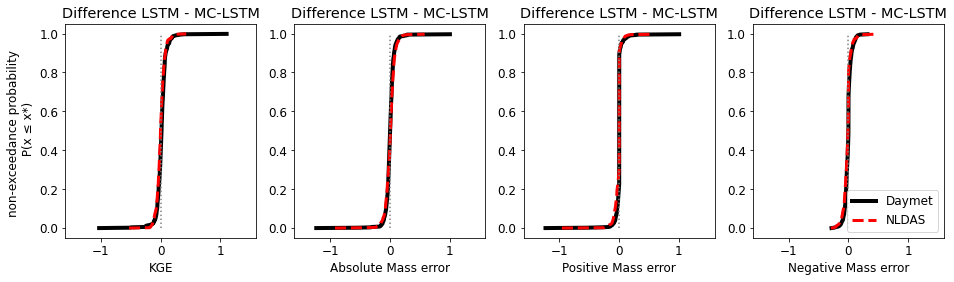

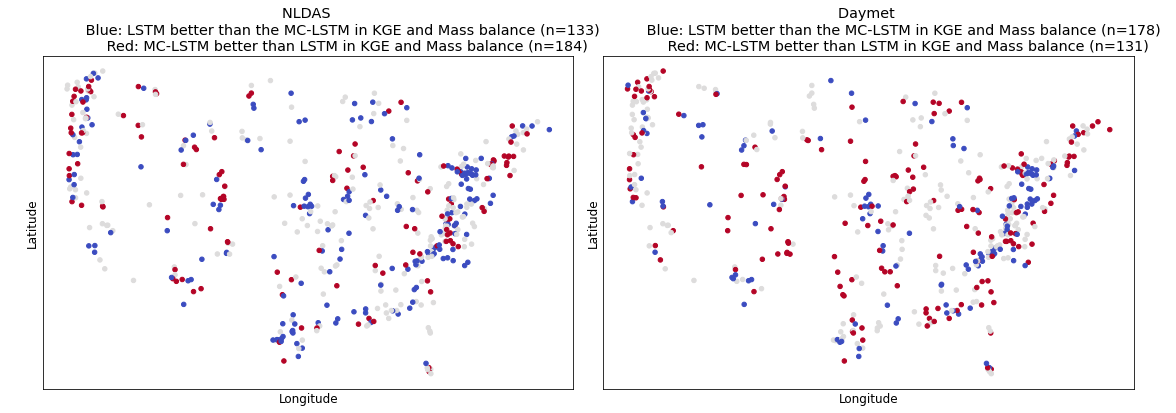

Time split: time_split1
Comparing LSTM agains the mass conserving model SAC-SMA
metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


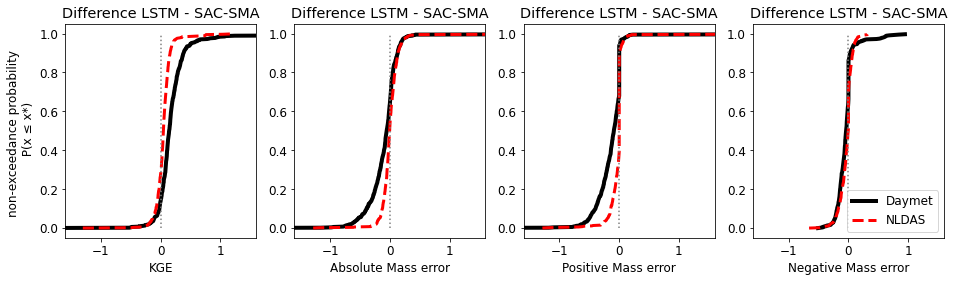

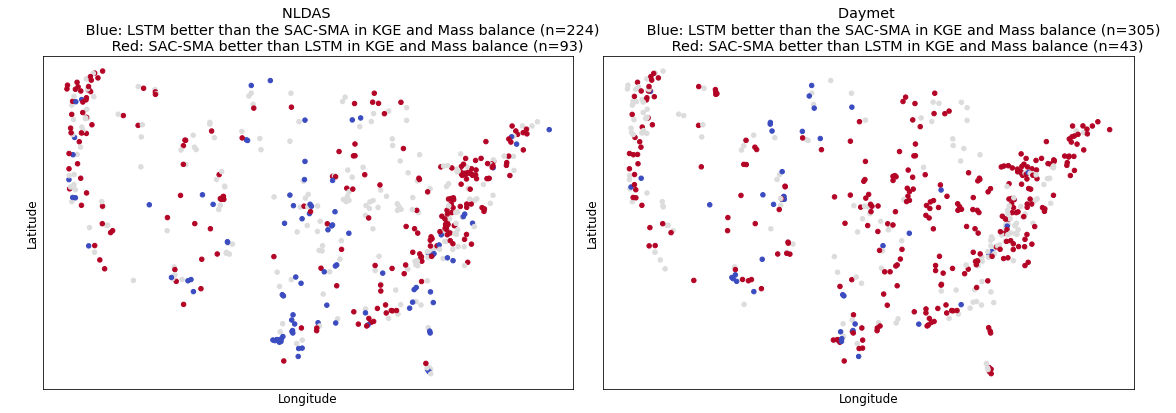

Time split: time_split2
Comparing LSTM agains the mass conserving model MC-LSTM
metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


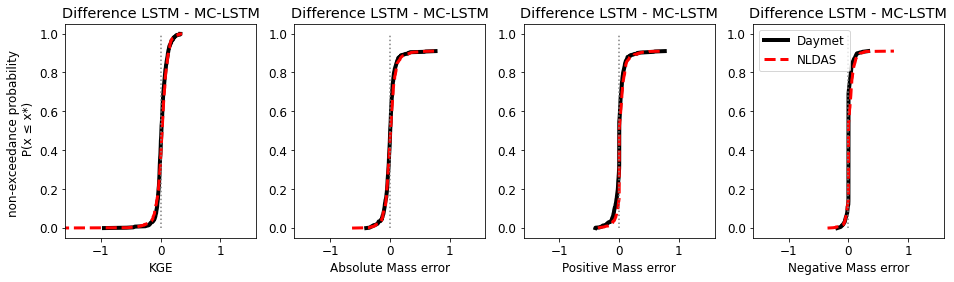

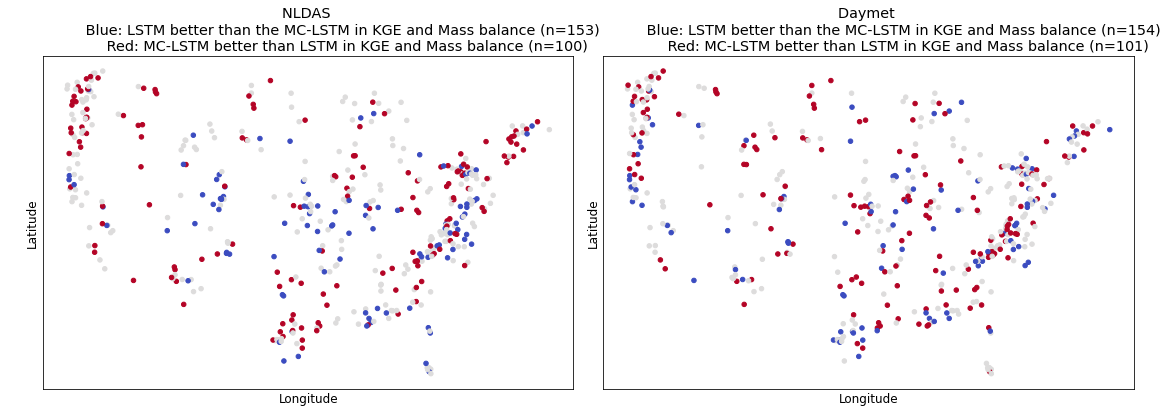

Time split: time_split2
Comparing LSTM agains the mass conserving model SAC-SMA
metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


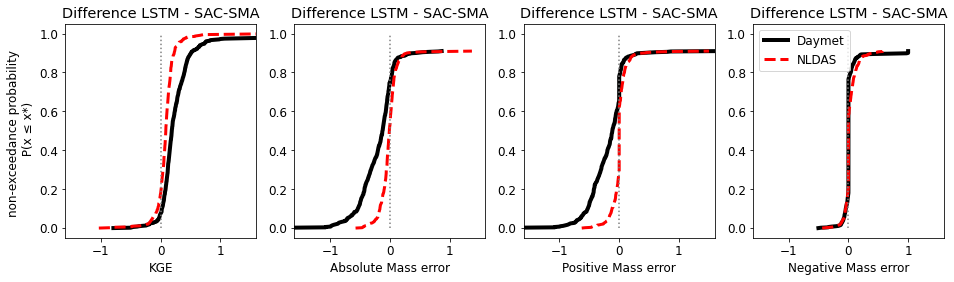

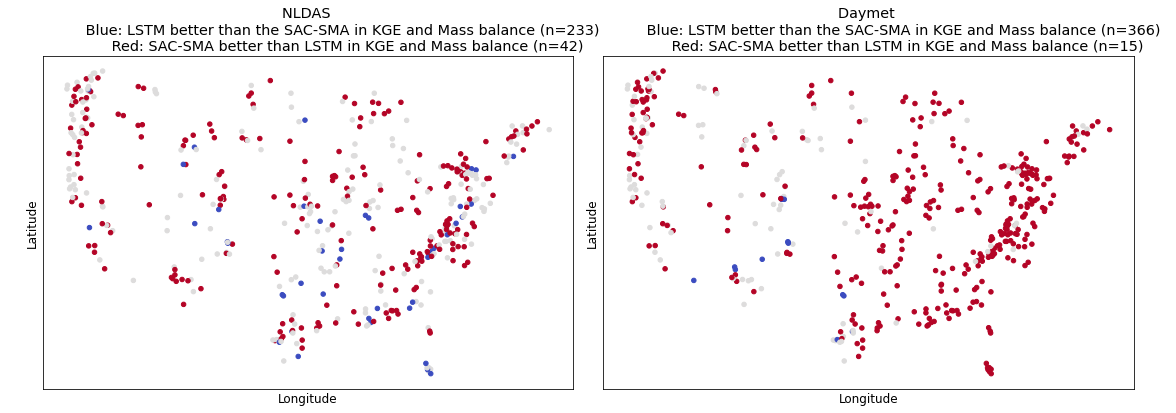

In [148]:
mc_model_names = {'mc':'MC-LSTM', 'sac':'SAC-SMA'}
ts_dict = {"time_split1":st1_dict, "time_split2":st2_dict}
for time_split in ["time_split1", "time_split2"]:
    for mc_model in ['mc','sac']:
        print(f"Time split: {time_split}")
        print(f"Comparing LSTM agains the mass conserving model {mc_model_names[mc_model]}")

        yvalues = list(range(len(np.sort(ts_dict[time_split]['daymet']["KGE"][mc_model]))))
        for i, _ in enumerate(yvalues):
            yvalues[i] = yvalues[i]/len(yvalues)
        yvalues_mass = list(range(len(np.sort(total_mass_error['daymet'][time_split]["absolute"][mc_model]))))
        for i, _ in enumerate(yvalues_mass):
            yvalues_mass[i] = yvalues_mass[i]/len(yvalues)


        print("metric", "KGE")
        metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
        for forcing_type in ['daymet','nldas']:
            print("forcing_type", forcing_type)
            _, wilcoxon_p = st.wilcoxon(ts_dict[time_split][forcing_type]["KGE"][mc_model],
                                         ts_dict[time_split][forcing_type]["KGE"]["lstm"])
            print("wilcoxon p value", np.round(wilcoxon_p,2))
            metric_dict["mc"] = ts_dict[time_split][forcing_type]["KGE"][mc_model]
            metric_dict["lstm"] = ts_dict[time_split][forcing_type]["KGE"]["lstm"]

        fig = plt.figure(figsize=cm2inch(40,10))
        xmin=-1.6
        xmax=1.6
        # ------- KGE plot differences -------- #
        ax = fig.add_subplot(1, 4, 1)
        diff_lstm_minus_mc_kge_daymet = calc_diffs('daymet', ts_dict[time_split], time_split, mc_model, metric="KGE")
        ax.plot(np.sort(diff_lstm_minus_mc_kge_daymet), yvalues, label='Daymet', c='k', lw=4)
        diff_lstm_minus_mc_kge_nldas = calc_diffs('nldas', ts_dict[time_split], time_split, mc_model, metric="KGE")
        ax.plot(np.sort(diff_lstm_minus_mc_kge_nldas), yvalues, '--', label='NLDAS', c='r', lw=3)
        ax.plot([0,0], [0,1], ':', c='grey')
        ax.set_xlim([xmin,xmax])
        ax.set_title(f"Difference LSTM - {mc_model_names[mc_model]}")
        ax.set_xlabel("KGE")
        ax.set_ylabel("non-exceedance probability \n P(x ≤ x*)")

        # ------- mass error plot differences -------- #
        # --- Absolute --- #
        ax = fig.add_subplot(1, 4, 2)
        diff_lstm_minus_mc_abs_daymet = calc_diffs('daymet', total_mass_error, time_split, mc_model, metric="absolute")
        ax.plot(np.sort(diff_lstm_minus_mc_abs_daymet), yvalues_mass, label='Daymet', c='k', lw=4)
        diff_lstm_minus_mc_abs_nldas = calc_diffs('nldas', total_mass_error, time_split, mc_model, metric="absolute")
        ax.plot(np.sort(diff_lstm_minus_mc_abs_nldas), yvalues_mass, '--', label='NLDAS', c='r', lw=3)
        ax.plot([0,0], [0,1], ':', c='grey')
        ax.set_xlim([xmin,xmax])
        ax.set_title(f"Difference LSTM - {mc_model_names[mc_model]}")
        ax.set_xlabel("Absolute Mass error")
        # --- Postitive --- #
        ax = fig.add_subplot(1, 4, 3)
        diff_lstm_minus_mc_pos_daymet = calc_diffs('daymet', total_mass_error, time_split, mc_model, metric="positive")
        ax.plot(np.sort(diff_lstm_minus_mc_pos_daymet), yvalues_mass, label='Daymet', c='k', lw=4)
        diff_lstm_minus_mc_pos_nldas = calc_diffs('nldas', total_mass_error, time_split, mc_model, metric="positive")
        ax.plot(np.sort(diff_lstm_minus_mc_pos_nldas), yvalues_mass, '--', label='NLDAS', c='r', lw=3)
        ax.plot([0,0], [0,1], ':', c='grey')
        ax.set_xlim([xmin,xmax])
        ax.set_title(f"Difference LSTM - {mc_model_names[mc_model]}")
        ax.set_xlabel("Positive Mass error")
        # --- Negative --- #
        ax = fig.add_subplot(1, 4, 4)
        diff_lstm_minus_mc_neg_daymet = calc_diffs('daymet', total_mass_error, time_split, mc_model, metric="negative")
        ax.plot(np.sort(diff_lstm_minus_mc_neg_daymet), yvalues_mass, label='Daymet', c='k', lw=4)
        diff_lstm_minus_mc_neg_nldas = calc_diffs('nldas', total_mass_error, time_split, mc_model, metric="negative")
        ax.plot(np.sort(diff_lstm_minus_mc_neg_nldas), yvalues_mass, '--', label='NLDAS', c='r', lw=3)
        ax.plot([0,0], [0,1], ':', c='grey')
        ax.set_xlim([xmin,xmax])
        ax.set_title(f"Difference LSTM - {mc_model_names[mc_model]}")
        ax.set_xlabel("Negative Mass error")


        plt.legend()
        plt.show()
        fig.tight_layout()
        # fig.savefig(f'../figs/kge_diff_{time_splitz[0]}.eps', dpi=600, format="eps")
        # fig.savefig(f'../figs/kge_diff_{time_splitz[0]}.png', dpi=600)
        plt.close()


        # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
        # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #

        lons = pd_attributes.loc[mass_basin_list_int[time_split], 'gauge_lon'].values
        lats = pd_attributes.loc[mass_basin_list_int[time_split], 'gauge_lat'].values
        df = pd.DataFrame(index=mass_basin_list_int[time_split], data={"latitude":lats, "longitude":lons})

        # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
        for iforc, forcing_type in enumerate(["nldas", "daymet"]):

            #---- need to get the index of the basin from regular basin list and mass analysis basin list
            best_kge=[]
            best_mass=[]
            mass_kge_same_or_diff=[]

            for model in ["mc", "lstm", "sac"]:

                for i, b in enumerate(basin_list_531_int):
                    if b in mass_basin_list_int[time_split]:
                        i_mass = mass_basin_list_int[time_split].index(b)
                    else:
                        continue

                    df.loc[b, f"{forcing_type}_{model}_kge"] = ts_dict[time_split][forcing_type]["KGE"][model][i]
                        
                    for mass_error in ["absolute", "positive", "negative"]:
                        df.loc[b, f"{forcing_type}_{model}_{mass_error}"] = \
                            total_mass_error[forcing_type][time_split][mass_error][model][i_mass]

        # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
        # plot where LSTM is better in KGE **AND** Mass
        fig = plt.figure(figsize=cm2inch(40,15))
        for iforc, forcing_type in enumerate(["nldas", "daymet"]):


            lstm_better_than_mc_both = (((df[f"{forcing_type}_lstm_kge"]-df[f"{forcing_type}_{mc_model}_kge"])>0) * \
                ((df[f"{forcing_type}_lstm_absolute"]-df[f"{forcing_type}_{mc_model}_absolute"])<0)) * 1

            lstm_worse_than_mc_both = (((df[f"{forcing_type}_lstm_kge"]-df[f"{forcing_type}_{mc_model}_kge"])<0) * \
                ((df[f"{forcing_type}_lstm_absolute"]-df[f"{forcing_type}_{mc_model}_absolute"])>0)) * -1

            c = lstm_better_than_mc_both + lstm_worse_than_mc_both

            ax = fig.add_subplot(1, 2, iforc+1)
            ax.scatter(pd_attributes.loc[mass_basin_list_int[time_split], 'gauge_lon'].values, 
                            pd_attributes.loc[mass_basin_list_int[time_split], 'gauge_lat'].values,
                            c=c,
                            s=20,
                            cmap='coolwarm',
                            vmin=-1, 
                            vmax=1)
            ax.set_title(f"{str(forcingz[forcing_type])} \n \
                Blue: LSTM better than the {mc_model_names[mc_model]} in KGE and Mass balance (n={lstm_better_than_mc_both.sum()})  \n \
                Red: {mc_model_names[mc_model]} better than LSTM in KGE and Mass balance (n={-1*lstm_worse_than_mc_both.sum()})")

            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")

            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

        plt.tight_layout()
        plt.show()
        plt.close()

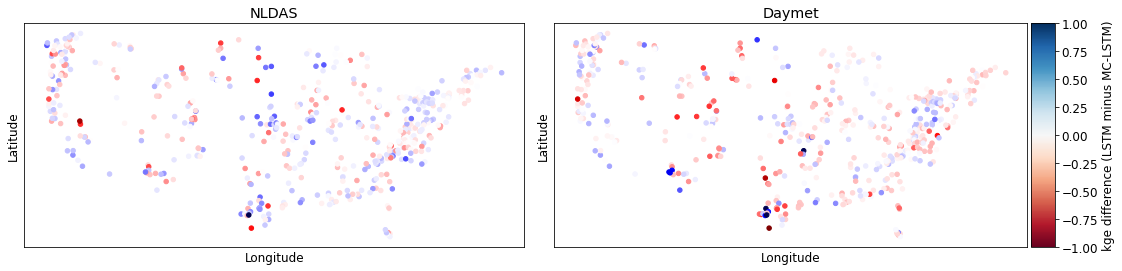

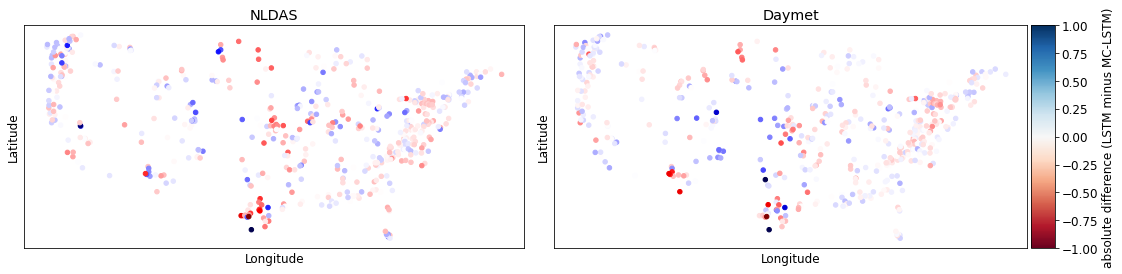

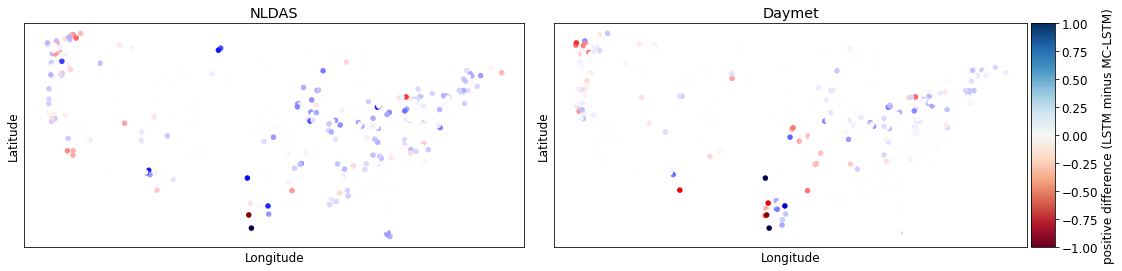

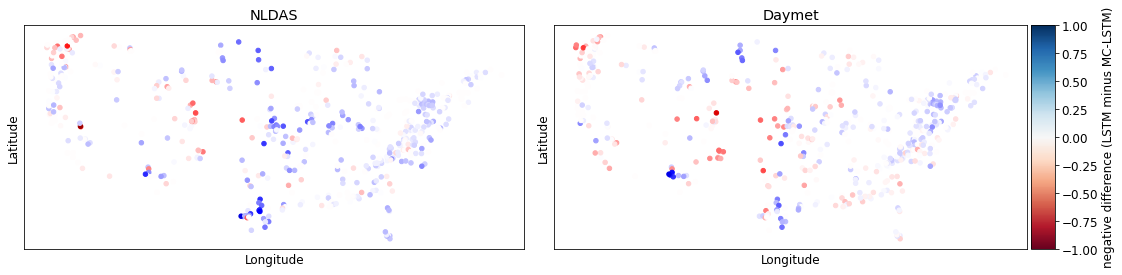

In [96]:
# - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
for metric in ["kge", "absolute", "positive", "negative"]:
    fig = plt.figure(figsize=cm2inch(40,10))
    for iforc, forcing_type in enumerate(["nldas", "daymet"]):
        ax = fig.add_subplot(1, 2, iforc+1)
        ax.scatter(pd_attributes.loc[mass_basin_list_int["time_split1"], 'gauge_lon'].values, 
                        pd_attributes.loc[mass_basin_list_int["time_split1"], 'gauge_lat'].values,
                        c=df[f"{forcing_type}_lstm_{metric}"] - df[f"{forcing_type}_mc_{metric}"],
                        s=20,
                        cmap='seismic',
                        vmin=-0.5, 
                        vmax=0.5)
        ax.set_title(f"{str(forcingz[forcing_type])}")

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        ax.set_xticks(ticks=[])
        ax.set_yticks(ticks=[])

        if iforc+1 ==2:
            clims = im.get_clim()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax, orientation='vertical')
            cbar.set_label(f"{metric} difference (LSTM minus MC-LSTM)", rotation=90)

    plt.tight_layout()
    plt.show()
    plt.close()
    
    

In [90]:

lstm_better_than_mc_both = (((df["daymet_lstm_kge"]-df["daymet_mc_kge"])>0) * \
    ((df["daymet_lstm_absolute"]-df["daymet_mc_absolute"])<0)) * 1

lstm_worse_than_mc_both = (((df["daymet_lstm_kge"]-df["daymet_mc_kge"])<0) * \
    ((df["daymet_lstm_absolute"]-df["daymet_mc_absolute"])>0)) * -1

lstm_better_than_mc_only_one = (lstm_better_than_mc_both==0) & (lstm_worse_than_mc_both==0)

print(f"N lstm_better_than_mc_both: {lstm_better_than_mc_both.sum()}")
print(f"N lstm_worse_than_mc_both: {lstm_worse_than_mc_both.sum()}")
print(f"N lstm_better_than_mc_only_one: {lstm_better_than_mc_only_one.sum()}")
print(f"should add to 530: {lstm_better_than_mc_both.sum()+lstm_worse_than_mc_both.sum()+lstm_better_than_mc_only_one.sum()}")

N lstm_better_than_mc_both: 178
N lstm_worse_than_mc_both: 131
N lstm_better_than_mc_only_one: 221
should add to 530: 530


metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


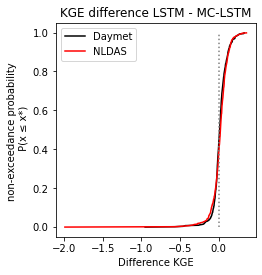

In [37]:
fig = plt.figure(figsize=cm2inch(20,10))

print("metric", "KGE")
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st2_dict[forcing_type]["KGE"]["mc"],
                                 st2_dict[forcing_type]["KGE"]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st2_dict[forcing_type]["KGE"]["mc"]
    metric_dict["lstm"] = st2_dict[forcing_type]["KGE"]["lstm"]

ax = fig.add_subplot(1, 2, 1)

diff_lstm_minus_mc = calc_diffs('daymet', st2_dict)
ax.plot(np.sort(diff_lstm_minus_mc), yvalues, label='Daymet', c='k')

diff_lstm_minus_mc = calc_diffs('nldas', st2_dict)
ax.plot(np.sort(diff_lstm_minus_mc), yvalues, label='NLDAS', c='r')

ax.plot([0,0], [0,1], ':', c='grey')
plt.legend()
plt.title("KGE difference LSTM - MC-LSTM")
plt.xlabel("Difference KGE")
plt.ylabel("non-exceedance probability \n P(x ≤ x*)")

plt.show()

fig.tight_layout()
# fig.savefig(f'../figs/kge_diff_{time_splitz[1]}.eps', dpi=600, format="eps")
# fig.savefig(f'../figs/kge_diff_{time_splitz[1]}.png', dpi=600)
plt.close()

metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.36


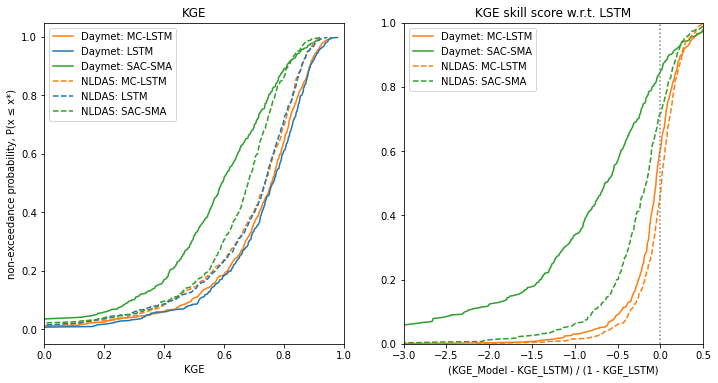

In [38]:
fig = plt.figure(figsize=cm2inch(30,15))

print("metric", "KGE")
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st1_dict[forcing_type]["KGE"]["mc"],
                                 st1_dict[forcing_type]["KGE"]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st1_dict[forcing_type]["KGE"]["mc"]
    metric_dict["lstm"] = st1_dict[forcing_type]["KGE"]["lstm"]

ax = fig.add_subplot(1, 2, 1)

ax.plot(np.sort(st1_dict['daymet']["KGE"]['mc']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(st1_dict['daymet']["KGE"]['lstm']), yvalues, label='Daymet: LSTM', c=colz[0])
ax.plot(np.sort(st1_dict['daymet']["KGE"]['sac']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(st1_dict['nldas']["KGE"]['mc']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(st1_dict['nldas']["KGE"]['lstm']), yvalues, label='NLDAS: LSTM', c=colz[0], ls='--')
ax.plot(np.sort(st1_dict['nldas']["KGE"]['sac']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.set_xlim([0,1])
plt.legend()
plt.title("KGE")
plt.xlabel("KGE")
plt.ylabel("non-exceedance probability, P(x ≤ x*)")


# --------------------------------------------------------------------------------------------------- #

kgess_st1_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}

for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['MC-LSTM'] = (np.array(st1_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))    
for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['SAC-SMA'] = (np.array(st1_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))  

colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.sort(kgess_st1_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(kgess_st1_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(kgess_st1_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(kgess_st1_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.plot([0,0], [0,1], ':', c='grey')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(KGE_Model - KGE_LSTM) / (1 - KGE_LSTM)")

plt.show()

fig.tight_layout()
# fig.savefig(f'../figs/kge_skill_score_{time_splitz[0]}.eps', dpi=600, format="eps")
# fig.savefig(f'../figs/kge_skill_score_{time_splitz[0]}.png', dpi=600)
plt.close()


metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


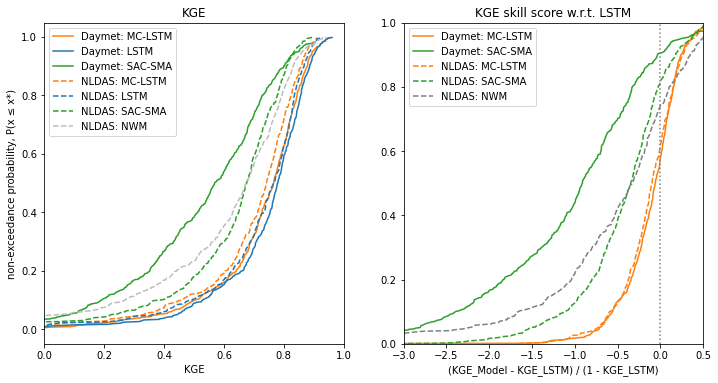

In [39]:
fig = plt.figure(figsize=cm2inch(30,15))

print("metric", "KGE")
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st2_dict[forcing_type]["KGE"]["mc"],
                                 st2_dict[forcing_type]["KGE"]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st2_dict[forcing_type]["KGE"]["mc"]
    metric_dict["lstm"] = st2_dict[forcing_type]["KGE"]["lstm"]

ax = fig.add_subplot(1, 2, 1)

ax.plot(np.sort(st2_dict['daymet']["KGE"]['mc']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(st2_dict['daymet']["KGE"]['lstm']), yvalues, label='Daymet: LSTM', c=colz[0])
ax.plot(np.sort(st2_dict['daymet']["KGE"]['sac']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(st2_dict['nldas']["KGE"]['mc']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['lstm']), yvalues, label='NLDAS: LSTM', c=colz[0], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['sac']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['nwm']), yvalues, label='NLDAS: NWM', c=colz[3], ls='--')
ax.set_xlim([0,1])
plt.legend()
plt.title("KGE")
plt.xlabel("KGE")
plt.ylabel("non-exceedance probability, P(x ≤ x*)")


# --------------------------------------------------------------------------------------------------- #

kgess_st2_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}

for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['MC-LSTM'] = (np.array(st2_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"])) 
for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['SAC-SMA'] = (np.array(st2_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
for forcing_type in ['nldas']:
    kgess_st2_dict[forcing_type]['NWM'] = (np.array(st2_dict[forcing_type]["KGE"]["nwm"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

    
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.sort(kgess_st2_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(kgess_st2_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(kgess_st2_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['NWM']), yvalues, label='NLDAS: NWM', c='grey', ls='--')
ax.plot([0,0], [0,1], ':', c='grey')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(KGE_Model - KGE_LSTM) / (1 - KGE_LSTM)")

plt.show()

fig.tight_layout()
# fig.savefig(f'../figs/kge_skill_score_{time_splitz[1]}.eps', dpi=600, format="eps")
# fig.savefig(f'../figs/kge_skill_score_{time_splitz[1]}.png', dpi=600)
plt.close()

metric mi
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


<Figure size 850.394x850.394 with 0 Axes>

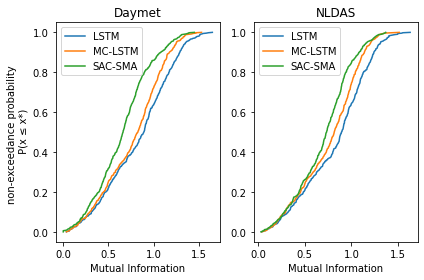

In [40]:
fig = plt.figure(figsize=cm2inch(30,30))

colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']
this_metric = 'mi'#'KGE'
yvalues = list(range(len(np.sort(st1_dict['daymet'][this_metric]['mc']))))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
    
fig = plt.figure()
print("metric", this_metric)
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st1_dict[forcing_type][this_metric]["mc"],
                                 st1_dict[forcing_type][this_metric]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st1_dict[forcing_type][this_metric]["mc"]
    metric_dict["lstm"] = st1_dict[forcing_type][this_metric]["lstm"]

ax = fig.add_subplot(1, 2, 1)

ax.plot(np.sort(st1_dict['daymet'][this_metric]['lstm']), yvalues, label='LSTM', c=colz[0])
ax.plot(np.sort(st1_dict['daymet'][this_metric]['mc']), yvalues, label='MC-LSTM', c=colz[1])
ax.plot(np.sort(st1_dict['daymet'][this_metric]['sac']), yvalues, label='SAC-SMA', c=colz[2])
ax.legend(fontsize=10)
plt.title("Daymet")
plt.xlabel("Mutual Information")
plt.ylabel("non-exceedance probability \n P(x ≤ x*)")

ax = fig.add_subplot(1, 2, 2)

ax.plot(np.sort(st1_dict['nldas'][this_metric]['lstm']), yvalues, label='LSTM', c=colz[0])
ax.plot(np.sort(st1_dict['nldas'][this_metric]['mc']), yvalues, label='MC-LSTM', c=colz[1])
ax.plot(np.sort(st1_dict['nldas'][this_metric]['sac']), yvalues, label='SAC-SMA', c=colz[2])
ax.legend(fontsize=10)
plt.title("NLDAS")
plt.xlabel("Mutual Information")

fig.tight_layout()
# fig.savefig('../figs/mutual_information_time_split1.eps', dpi=600, format="eps")
# fig.savefig('../figs/mutual_information_time_split1.png', dpi=600)
plt.show()
plt.close()

# Try to figure out where the mass balance results are in favor of each...

In [41]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import scipy

In [42]:
len(total_mass_error["daymet"]["time_split1"]['positive']["lstm"])

530

In [43]:
len(mass_basin_list["time_split1"])

530

In [44]:
regressor_columns = ['q_mean', 'runoff_ratio', 'slope_fdc', 'baseflow_index',
       'stream_elas', 'q5', 'q95', 'high_q_freq', 'high_q_dur',
       'low_q_freq', 'low_q_dur', 'zero_q_freq', 'hfd_mean',
       'geol_1st_class', 'glim_1st_class_frac', 'carbonate_rocks_frac',
       'geol_porostiy', 'geol_permeability', 'p_mean', 'pet_mean',
       'p_seasonality', 'frac_snow', 'aridity', 'high_prec_freq',
       'high_prec_dur', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'gauge_lat', 'gauge_lon',
       'elev_mean', 'area_gages2', 'area_geospa_fabric',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'max_water_content',
       'sand_frac', 'silt_frac', 'clay_frac', 'water_frac',
       'organic_frac', 'other_frac', 'frac_forest', 'lai_max', 'gvf_max',
       'root_depth_50', 'root_depth_99','basin_hydro_unit']


In [45]:
regressors = pd_attributes.loc[[int(basin) for basin in mass_basin_list["time_split1"]],regressor_columns]
regressors['basin_hydro_unit'] = [int(unit) for unit in regressors['basin_hydro_unit']]
regressors = regressors.dropna(axis='columns')

FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR lstm-mc
0.279315227575225
FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR lstm-sac
0.39437309237591944
FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR mc-sac
0.34662177709004016


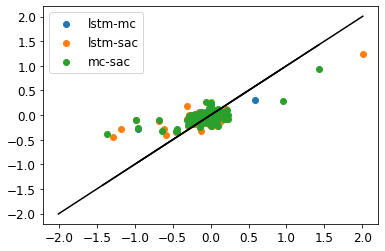

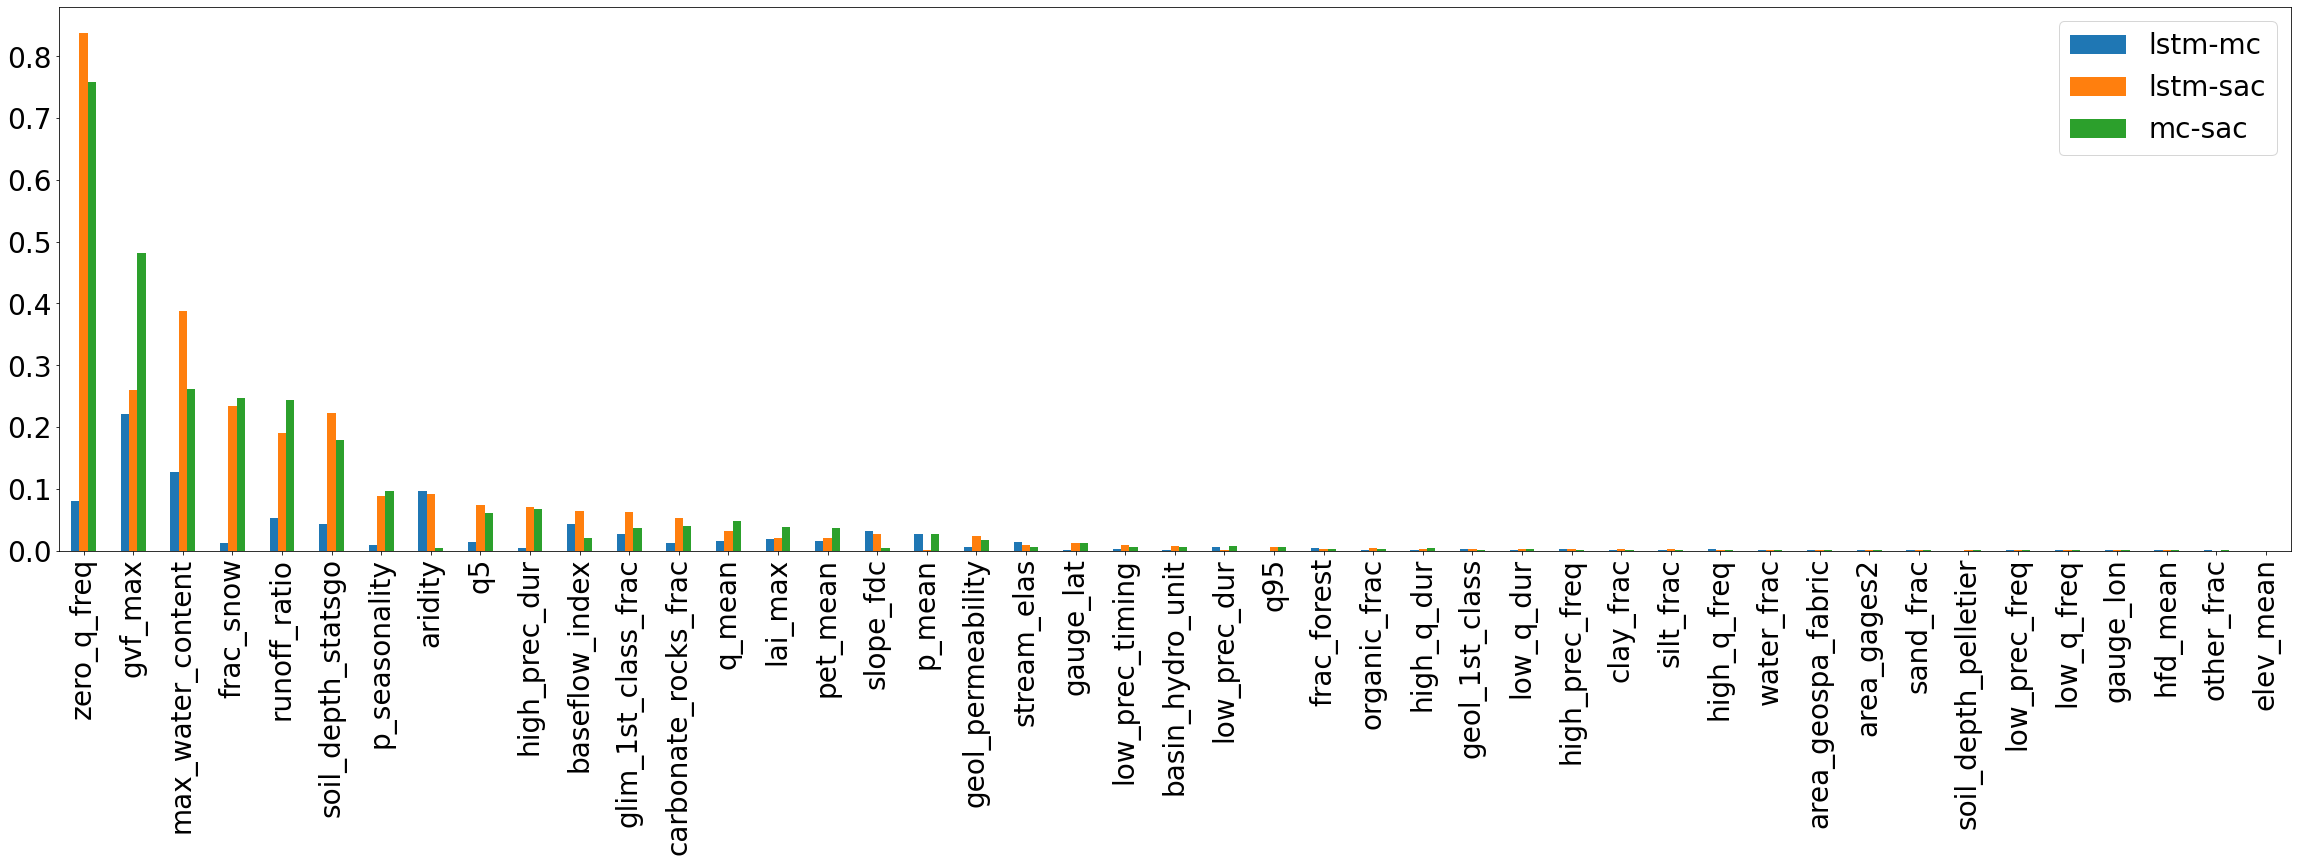

FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR lstm-mc
0.3284446787504395
FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR lstm-sac
0.4165469322919221
FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR mc-sac
0.34528676534622815


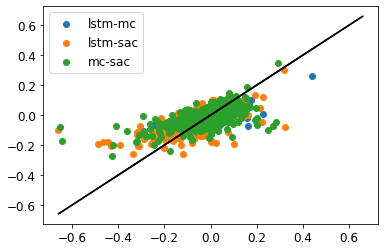

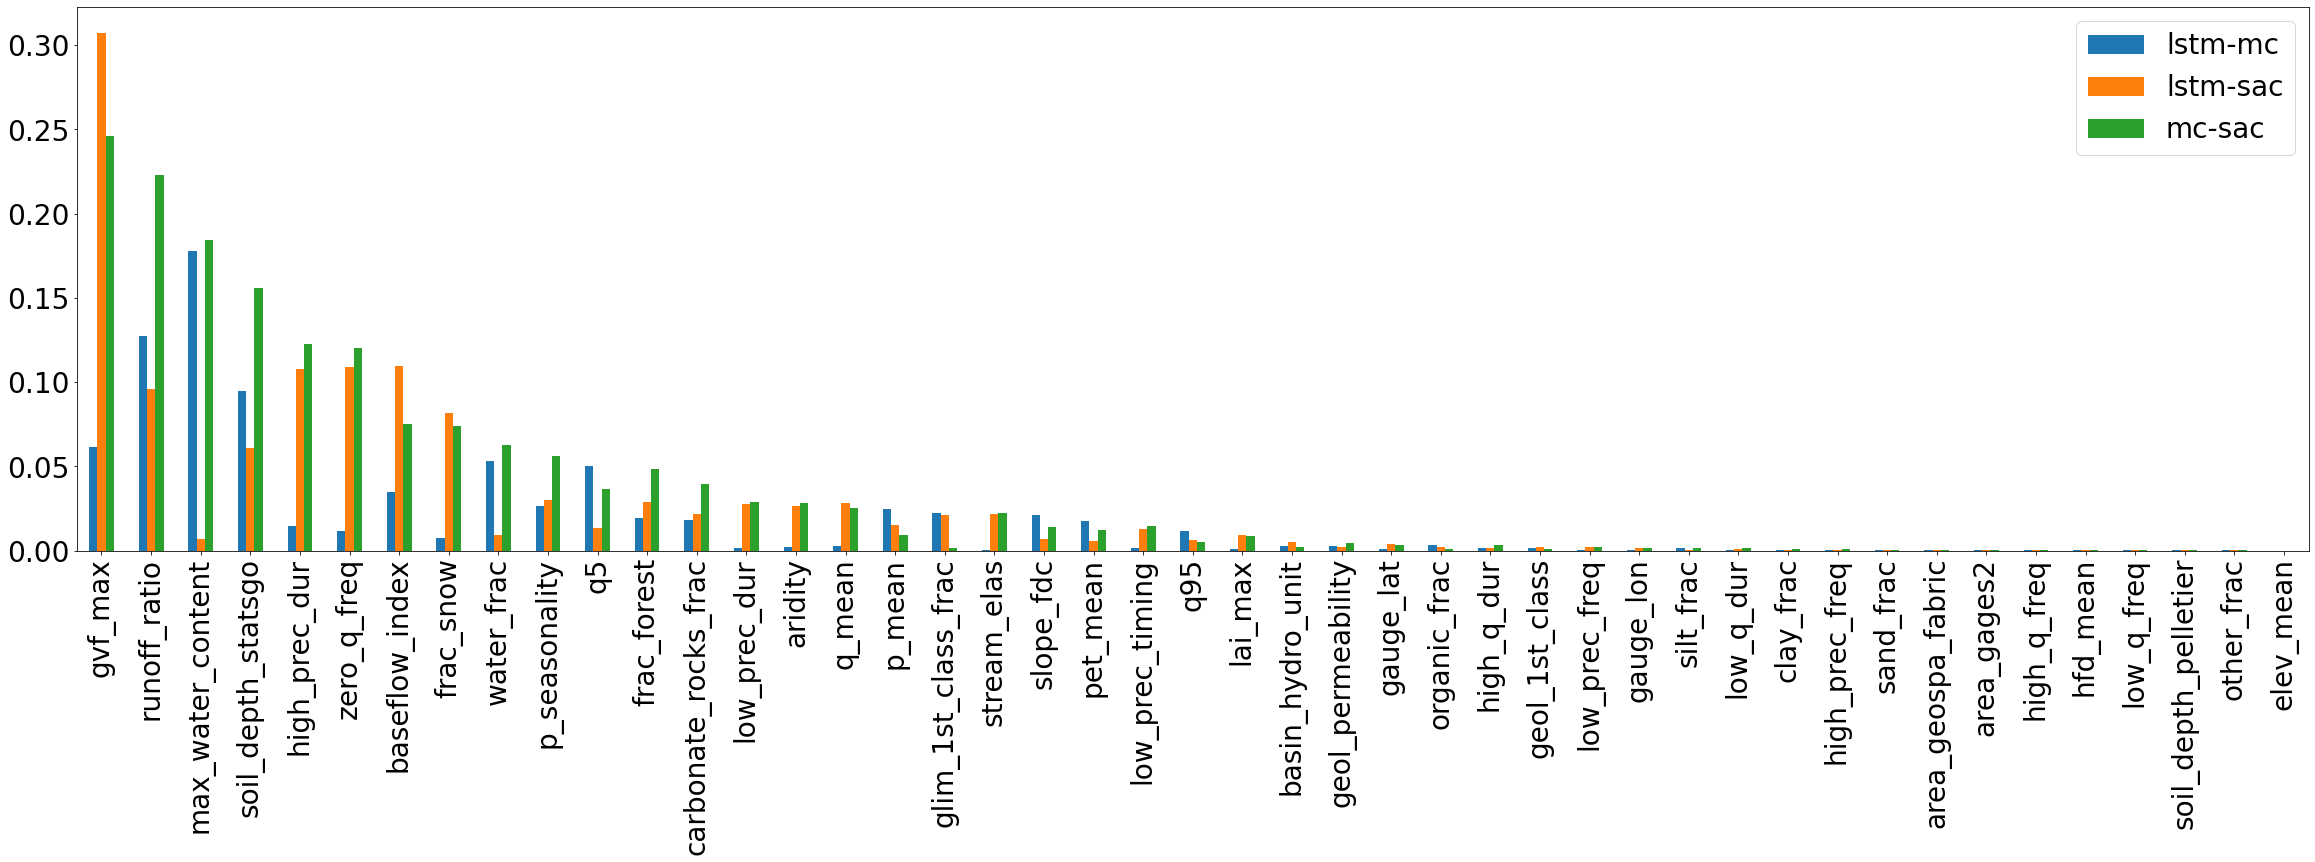

FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-mc
0.24437044894257776
FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-sac
0.33530762265208514
FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR mc-sac
0.27667084863261804


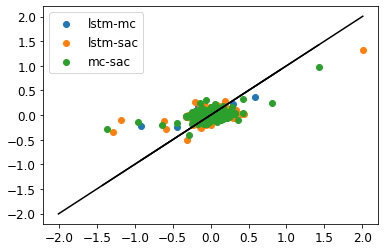

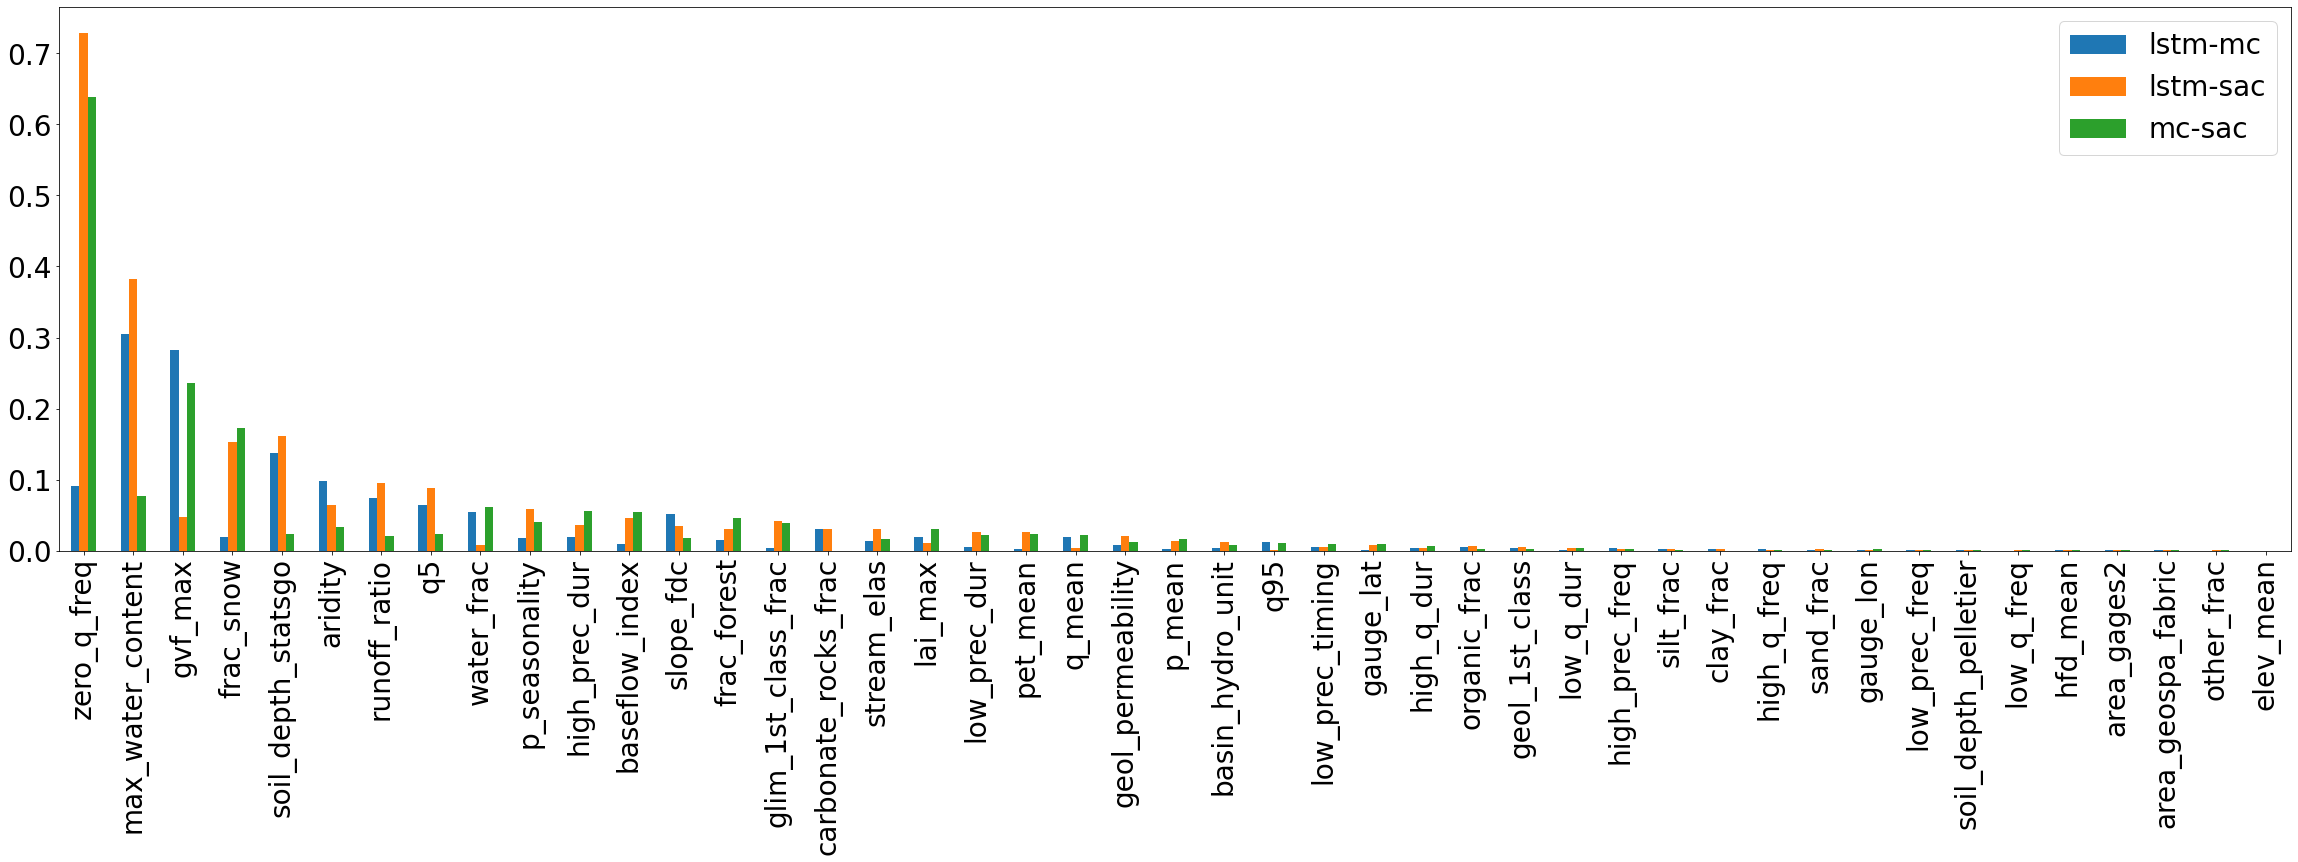

FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR lstm-mc
0.315671276658646
FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR lstm-sac
0.41454454285101416
FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR mc-sac
0.37682243553421424


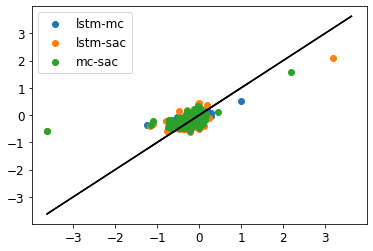

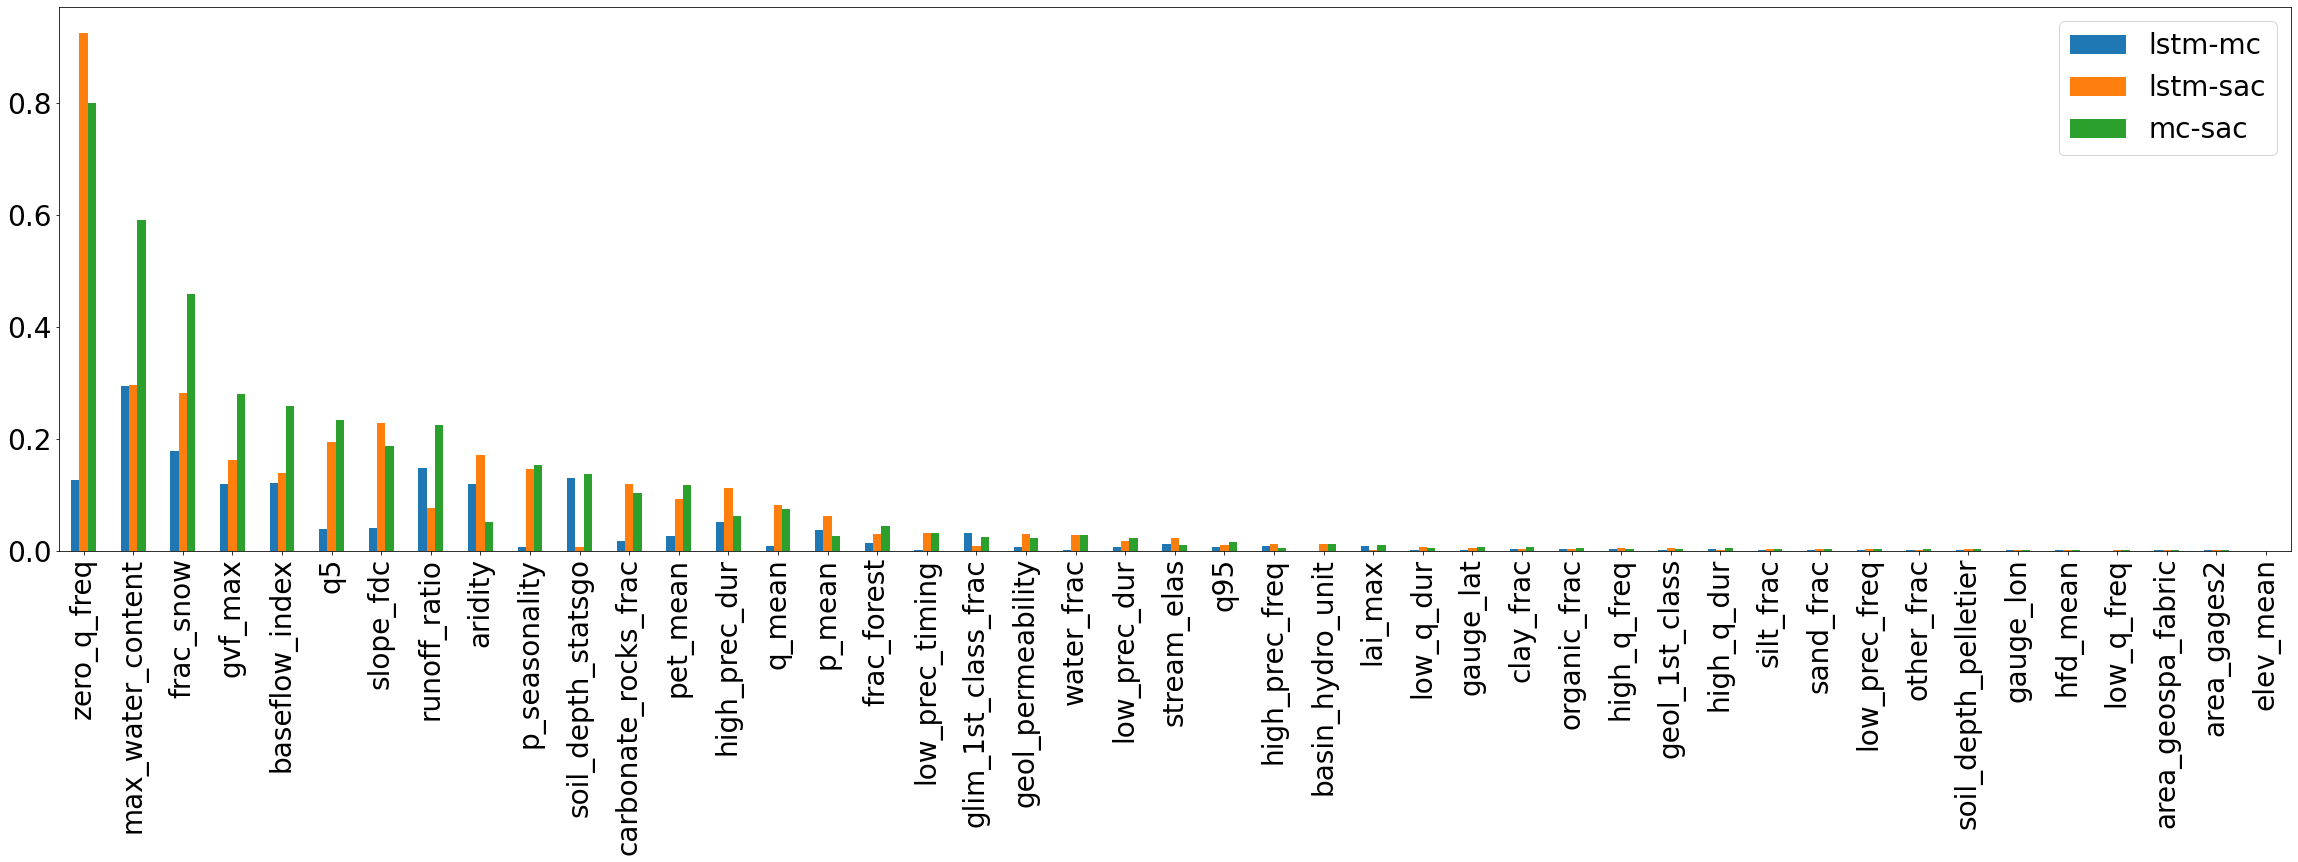

FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR lstm-mc
0.3033520315713286
FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR lstm-sac
0.19703906054273135
FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR mc-sac
0.20561553950295552


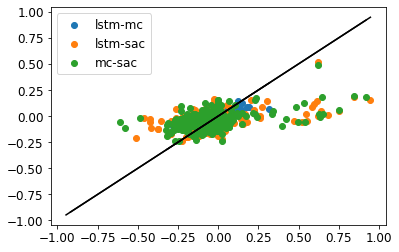

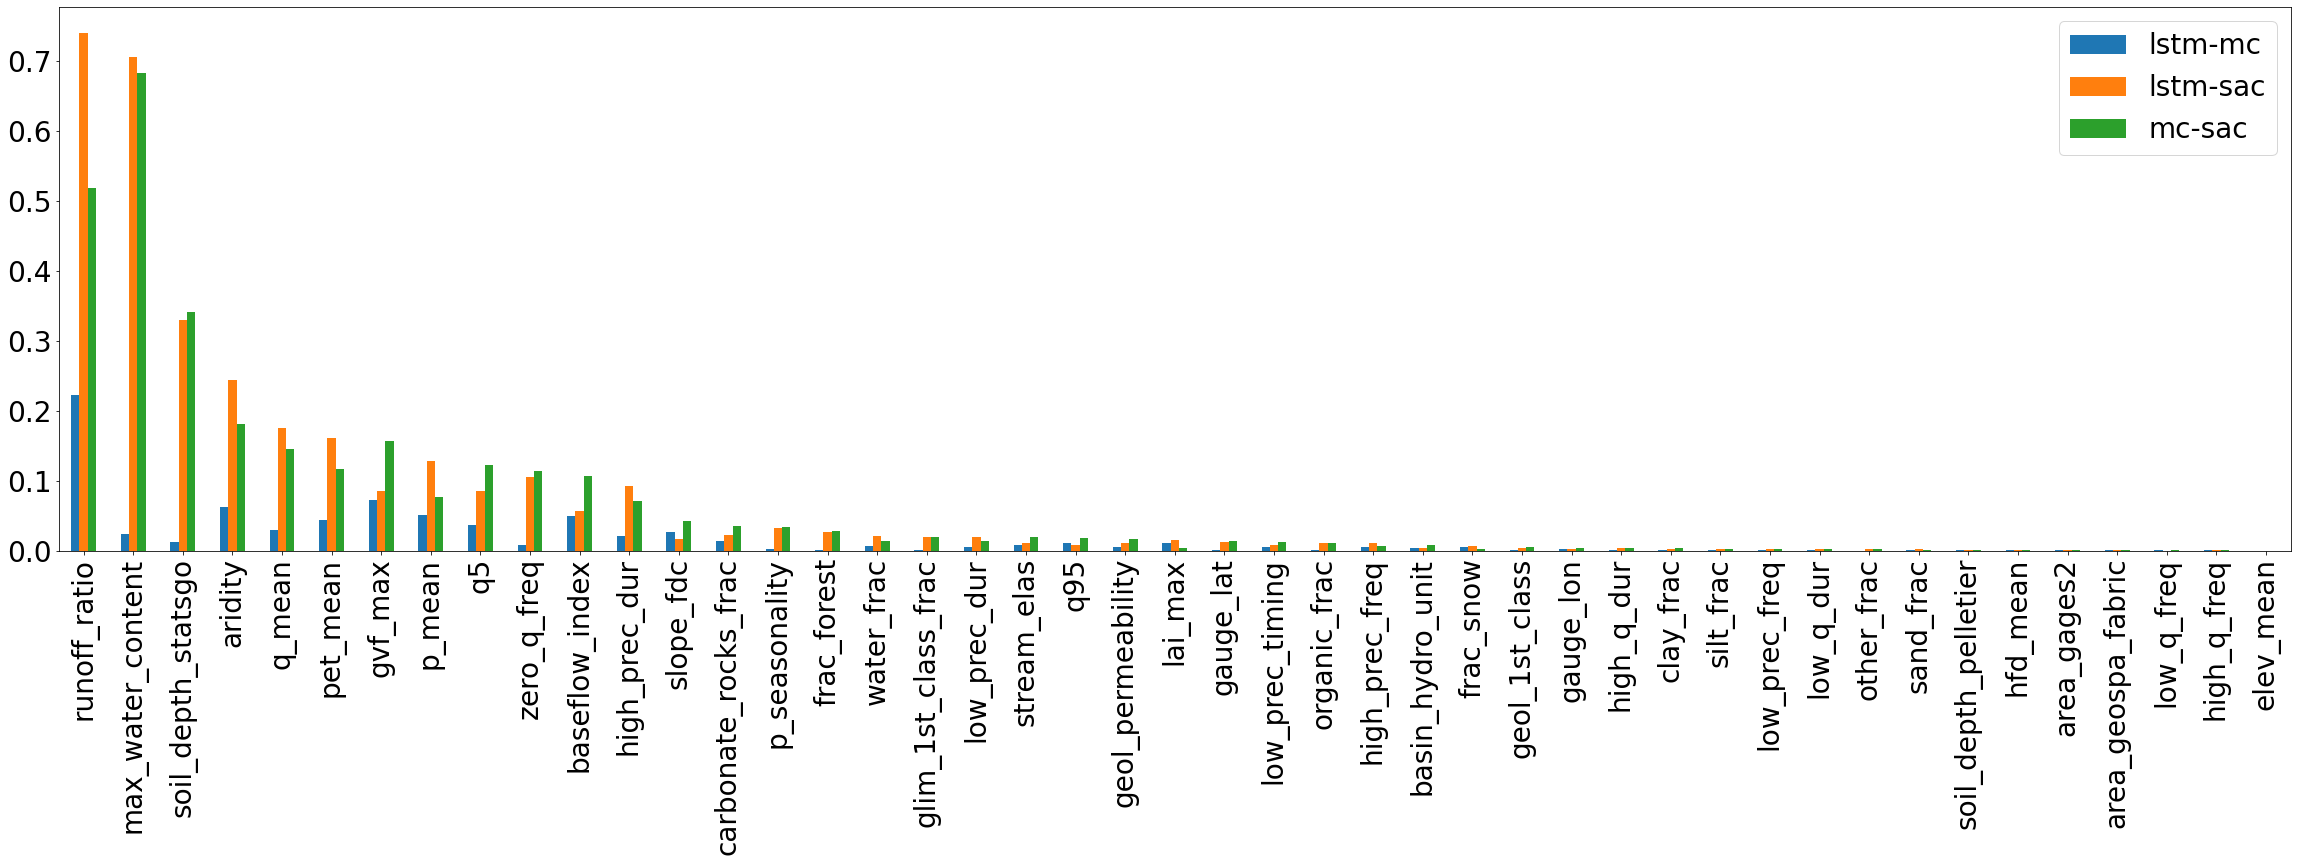

FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-mc
0.23669157728526602
FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-sac
0.34492607969230094
FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR mc-sac
0.3456263625891215


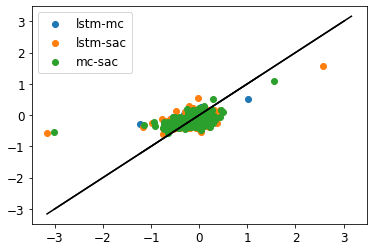

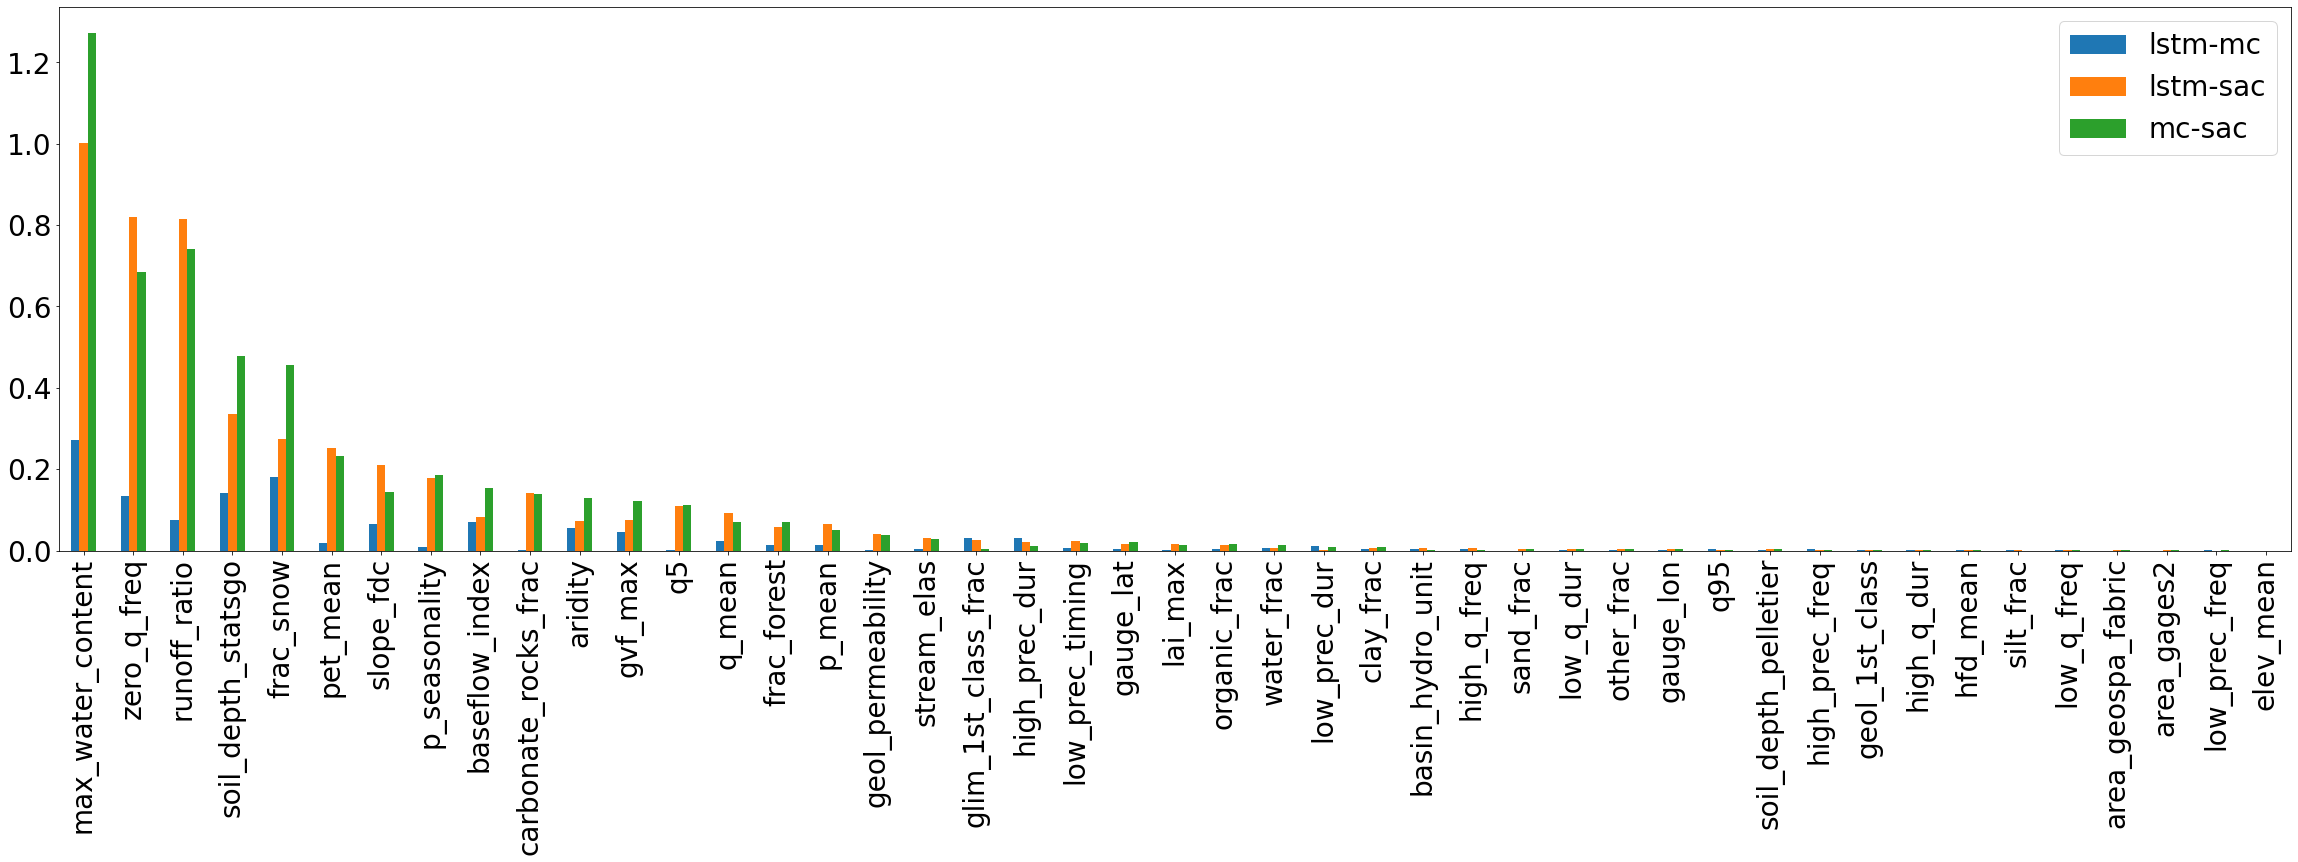

In [46]:

for forcing in ["nldas", "daymet"]:
    
    for err_type in ['positive', 'negative', 'absolute']:
        
        coef_dict={}
        rcParams.update({'font.size': 12})
        
        for regress_models in [["lstm", "mc"], ["lstm", "sac"], ["mc", "sac"]]:
            
            print("FORCING: ", forcing)
            print("MASS ERROR TYPE: ", err_type)
            model_diff_name = str(regress_models[0])+'-'+str(regress_models[1])
            print("MODEL PAIR", model_diff_name)

            y = np.array(total_mass_error[forcing]["time_split1"][err_type][regress_models[0]]) - \
                np.array(total_mass_error[forcing]["time_split1"][err_type][regress_models[1]])

            X = regressors

            regr = linear_model.LinearRegression()
            regr.fit(X, y)

            predicted = regr.predict(regressors)

            print(r2_score(y, predicted))
            indx = f"{regress_models[0]}-{regress_models[1]}"
            plt.scatter(y, predicted, label=indx)
            plot_limit = np.max([np.abs(predicted), np.abs(y)])

            plt.plot([-plot_limit, plot_limit],[-plot_limit, plot_limit], c='k')
            coef_dict[indx] = np.abs(regr.coef_)
#         plt.xlim([-.75,.5])
#         plt.ylim([-.75,.5])
        plt.legend()
        plt.show()
        plt.close()

        regression_coefs = pd.DataFrame(index=regressors.columns.values, data=coef_dict)
        regression_coefs['sum_coef'] = regression_coefs.sum(axis=1)
        regression_coefs = regression_coefs.sort_values(by=['sum_coef'], ascending=False)
        regression_coefs = regression_coefs.drop(['sum_coef'], axis=1)
        rcParams.update({'font.size': 28})
        ax = regression_coefs.plot.bar(figsize=(40,10))
        
        plt.show()
        plt.close()

In [47]:
rcParams.update({'font.size': 12})

In [48]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [49]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [50]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, 
                 max_depth=None, max_samples=1,
                 min_weight_fraction_leaf=0):

    index_labs = feature_list
    
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(16.5,5.02))
    grid = plt.GridSpec(1, 10, wspace=0.33333)
    plt.subplot(grid[0, 0:3])
    
    if np.isnan(X).sum()>0:
        print("nan in X")
        print(np.isnan(X).sum())
    if np.isnan(y).sum()>0:
        print("nan in y")
    
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        
        rf.fit(X_train, y_train)
        
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    #Force the lims for readability
#     omax=2
#     omin=-2
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 3:11])
    feature_importances.sort_values('total_importance', ascending=False).plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [51]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=None, ynormal=None, xlog=None, ylog=None):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [52]:
do_regression=False
if do_regression:
    df = pd_attributes.loc[[int(basin) for basin in mass_basin_list["time_split1"]],regressor_columns]
    df['basin_hydro_unit'] = [int(unit) for unit in df['basin_hydro_unit']]
    df = df.dropna(axis='columns')
    regressor_attributes = df.columns.values
    rcParams.update({'font.size': 12})
    for forcing in ["nldas", "daymet"]:

        for err_type in ['positive', 'negative', 'absolute']:

            for model_pair in [["lstm", "mc"], ["lstm", "sac"], ["mc", "sac"]]:

                print("FORCING: ", forcing)
                print("MASS ERROR TYPE: ", err_type)
                model_diff_name = str(model_pair[0])+'-'+str(model_pair[1])
                print("MODEL PAIR", model_diff_name)

                df[model_diff_name] = \
                    np.array(total_mass_error[forcing]["time_split1"][err_type][model_pair[0]]) - \
                    np.array(total_mass_error[forcing]["time_split1"][err_type][model_pair[1]])

                # 528 basins / 16 splits = 33 samples in each split.
                n_splits = 14 

                X, y = set_X_y(df, regressor_attributes, model_diff_name, 
                               xnormal=False, ynormal=False, 
                               xlog=False, ylog=False)

    #             y_copy = copy.deepcopy(y)
    #             y_copy.sort()
    #             y_copy = y_copy
    #             plt.plot(y_copy, np.array(list(range(y_copy.shape[0])))/y_copy.shape[0])
    #             plt.plot([0,0],[0,1], '--', c="k")
    #             plt.show()
    #             plt.close()

                kf = KFold(n_splits=n_splits, shuffle=True)
                y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                                n_estimators=100,random_state=100,
                                criterion='mae', min_samples_leaf=1,
                                max_depth=None, max_samples=1,
                                min_weight_fraction_leaf=0)

    #             break
    #         break
    #     break

In [53]:
for i in range(df.shape[1]): 
    print(i, df.iloc[:,i].sum())

0 20755.430200000003
1 -50059.71236
2 359.9638856781793
3 68.62986394711334
4 20.605444996850565
5 -48.02441895026277
6 359.3266327421999
7 70.83179875358474
8 13.094609354215208
9 -57.73718939936953
10 334.83439549624467
11 71.24053974402656
12 31.85068660342912
13 -39.38985314059745
14 374.41358314519965
15 66.25064278772334
16 16.177859439805616
17 -50.07278334791772
18 381.051709575991
19 67.20006680683582
20 13.944871158862952
21 -53.25519564797287
22 292.8907405063991
23 120.89540417870133
24 91.1261128460417
25 -29.769291332659638


In [115]:
df

,latitude,longitude,nldas_mc_kge,nldas_mc_absolute,nldas_mc_positive,nldas_mc_negative,nldas_lstm_kge,nldas_lstm_absolute,nldas_lstm_positive,nldas_lstm_negative,...,daymet_mc_positive,daymet_mc_negative,daymet_lstm_kge,daymet_lstm_absolute,daymet_lstm_positive,daymet_lstm_negative,daymet_sac_kge,daymet_sac_absolute,daymet_sac_positive,daymet_sac_negative
1022500,44.60797,-67.93524,0.833489,0.135043,0.135043,0.000000,0.766723,0.207579,0.207579,0.000000,...,0.047994,0.000000,0.933328,0.029035,0.029035,0.000000,0.786900,0.102869,0.102869,0.000000
1031500,45.17501,-69.31470,0.862569,0.075605,0.075605,0.000000,0.874732,0.084370,0.084370,0.000000,...,0.077497,0.000000,0.909447,0.040105,0.040105,0.000000,0.823950,0.114005,0.114005,0.000000
1047000,44.86920,-69.95510,0.870278,0.038100,0.000000,-0.038100,0.844088,0.073179,0.000000,-0.073179,...,0.000000,-0.068285,0.883891,0.041435,0.000000,-0.041435,0.838240,0.049165,0.000000,-0.049165
1052500,44.87739,-71.05749,0.894275,0.053987,0.000000,-0.053987,0.824300,0.071877,0.000000,-0.071877,...,0.050456,0.000000,0.895558,0.001743,0.000000,-0.001743,0.818511,0.062824,0.062824,0.000000
1054200,44.39044,-70.97964,0.726252,0.007705,0.000000,-0.007705,0.736506,0.036542,0.000000,-0.036542,...,0.000000,-0.039035,0.715755,0.036412,0.000000,-0.036412,0.586016,0.032340,0.000000,-0.032340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14308990,42.82318,-123.12589,0.929400,0.346060,0.000000,-0.346060,0.904531,0.367306,0.000000,-0.367306,...,0.000625,0.000000,0.926885,0.027524,0.027524,0.000000,0.810629,0.364170,0.364170,0.000000
14309500,42.80400,-123.61091,0.922480,0.070252,0.000000,-0.070252,0.813739,0.073275,0.000000,-0.073275,...,0.168862,0.000000,0.951581,0.139356,0.139356,0.000000,0.872838,0.381160,0.381160,0.000000
14316700,43.34984,-122.72894,0.888258,0.023933,0.000000,-0.023933,0.945283,0.066152,0.000000,-0.066152,...,0.000000,-0.001321,0.945430,0.015613,0.015613,0.000000,0.858038,0.045246,0.045246,0.000000
14325000,42.89150,-124.07065,0.730592,0.054016,0.054016,0.000000,0.785591,0.002362,0.002362,0.000000,...,0.197263,0.000000,0.819546,0.211793,0.211793,0.000000,0.590321,0.234784,0.234784,0.000000


In [55]:
df.columns.values

array(['latitude', 'longitude', 'nldas_mc_kge', 'nldas_mc_absolute',
       'nldas_mc_positive', 'nldas_mc_negative', 'nldas_lstm_kge',
       'nldas_lstm_absolute', 'nldas_lstm_positive',
       'nldas_lstm_negative', 'nldas_sac_kge', 'nldas_sac_absolute',
       'nldas_sac_positive', 'nldas_sac_negative', 'daymet_mc_kge',
       'daymet_mc_absolute', 'daymet_mc_positive', 'daymet_mc_negative',
       'daymet_lstm_kge', 'daymet_lstm_absolute', 'daymet_lstm_positive',
       'daymet_lstm_negative', 'daymet_sac_kge', 'daymet_sac_absolute',
       'daymet_sac_positive', 'daymet_sac_negative'], dtype=object)

FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR lstm-mc


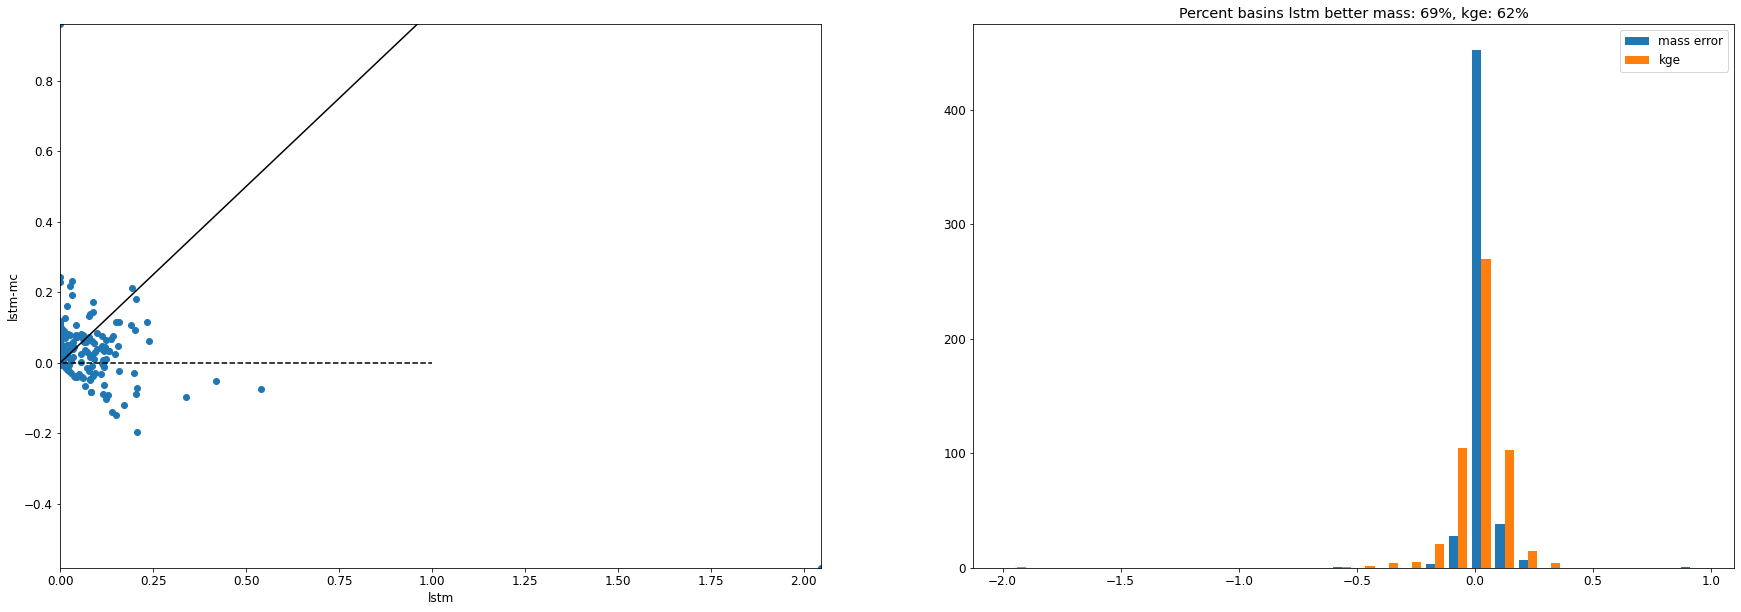

FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR lstm-sac


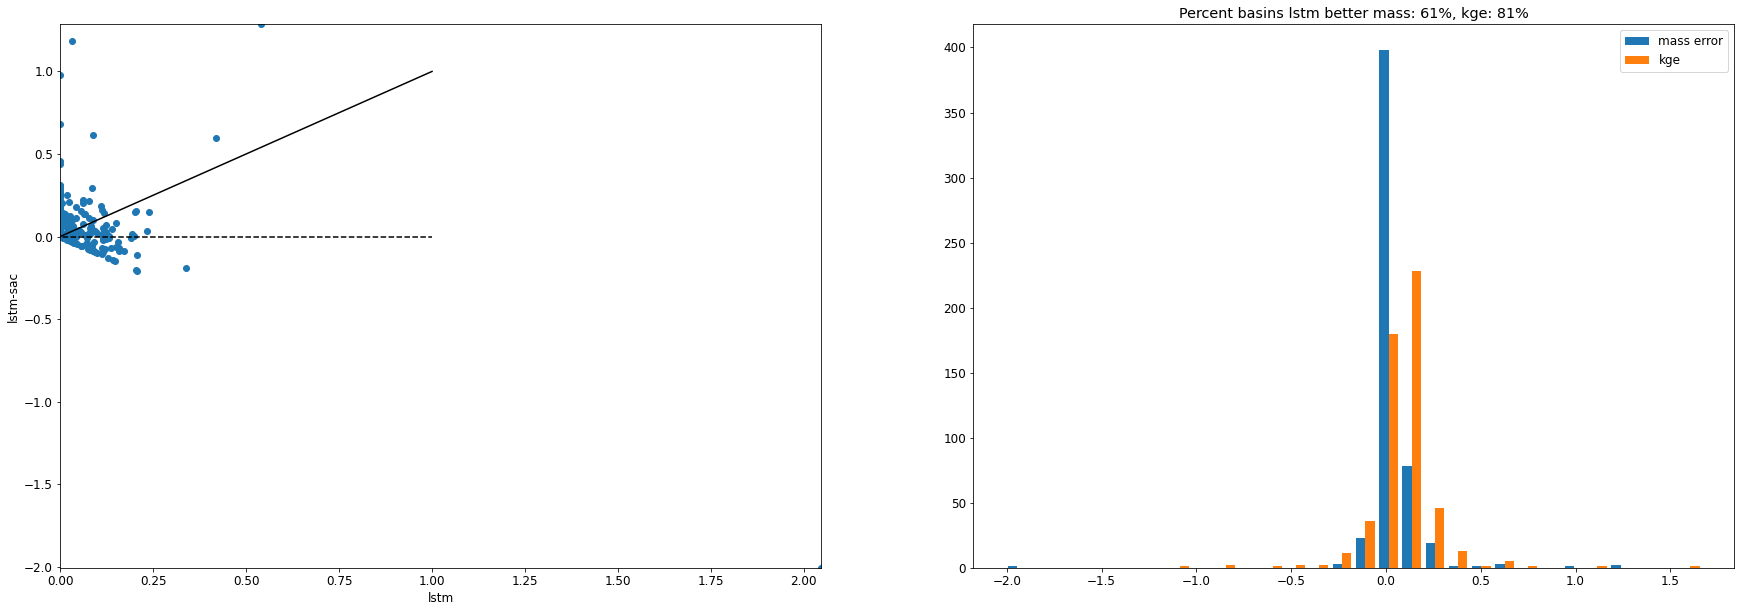

FORCING:  nldas
MASS ERROR TYPE:  positive
MODEL PAIR mc-sac


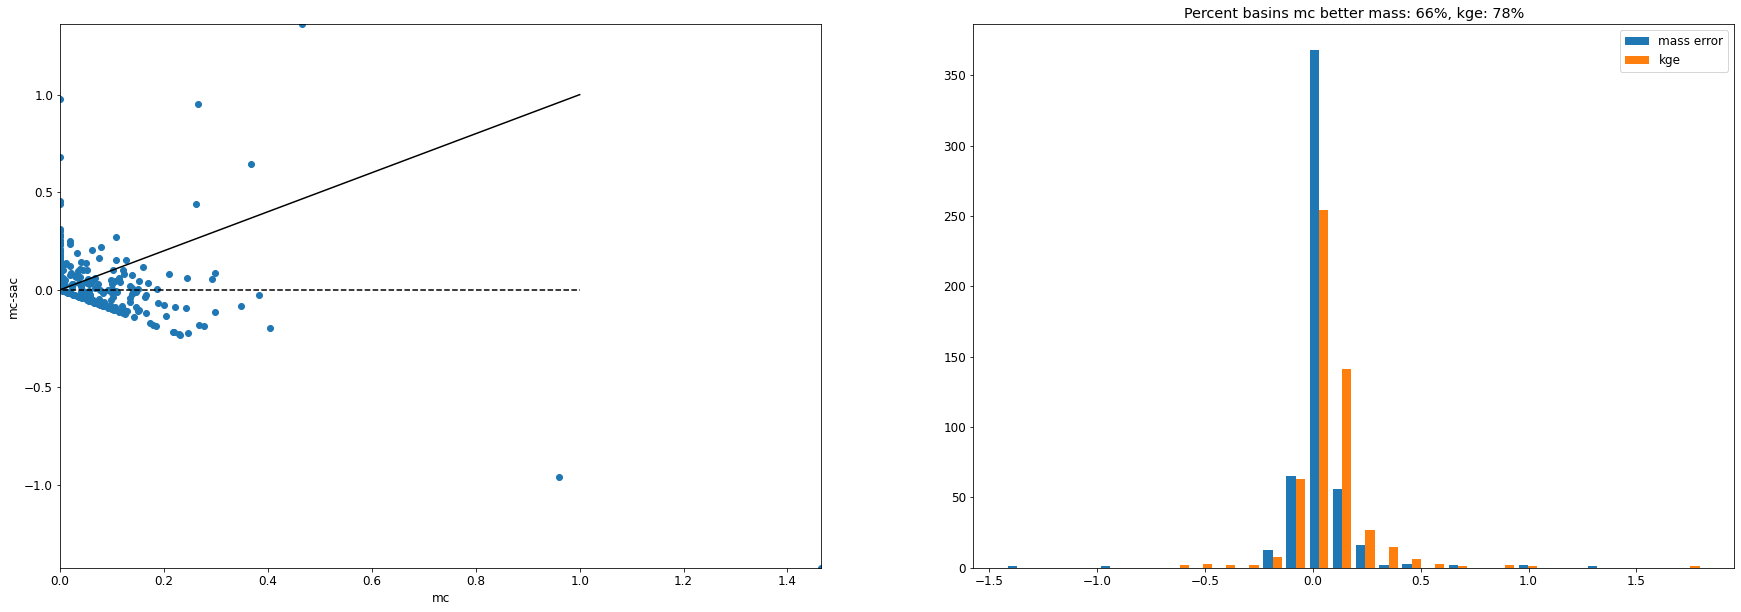

FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR lstm-mc


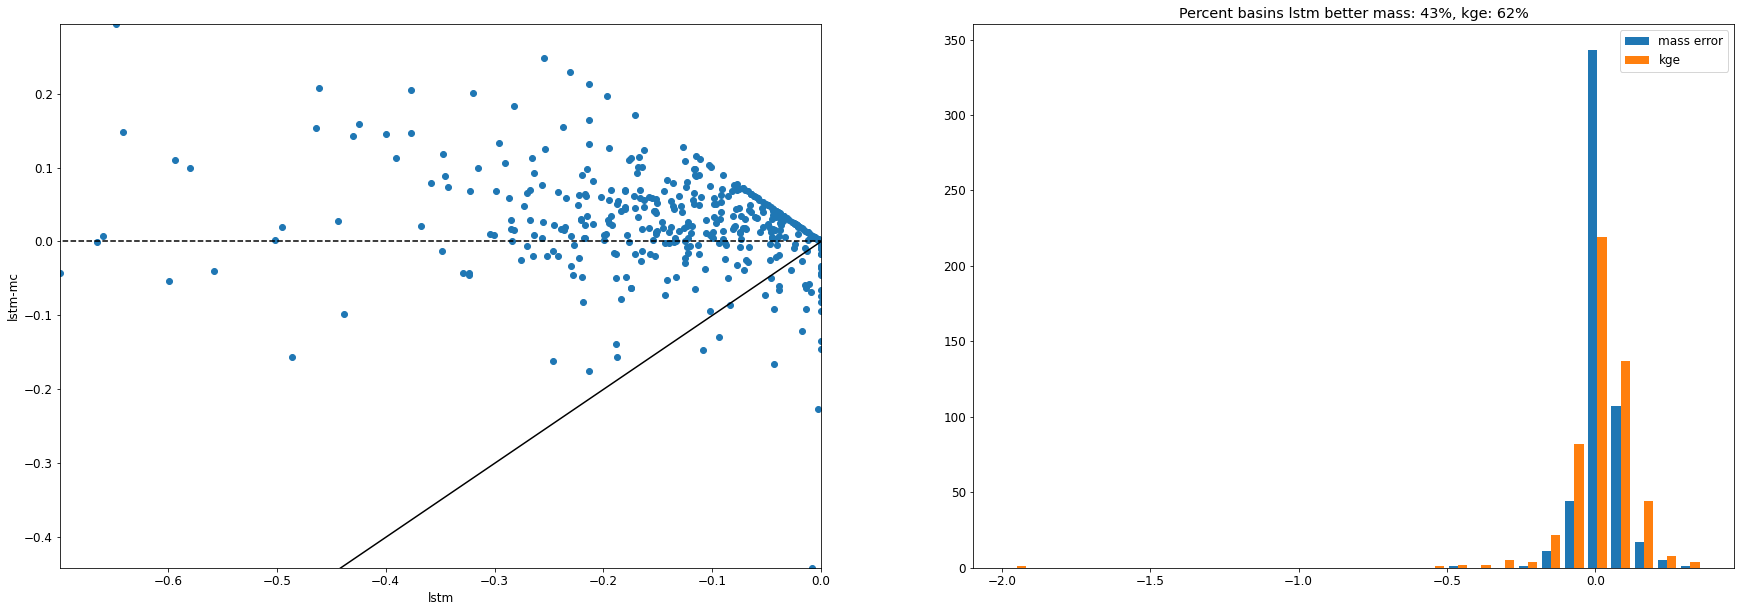

FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR lstm-sac


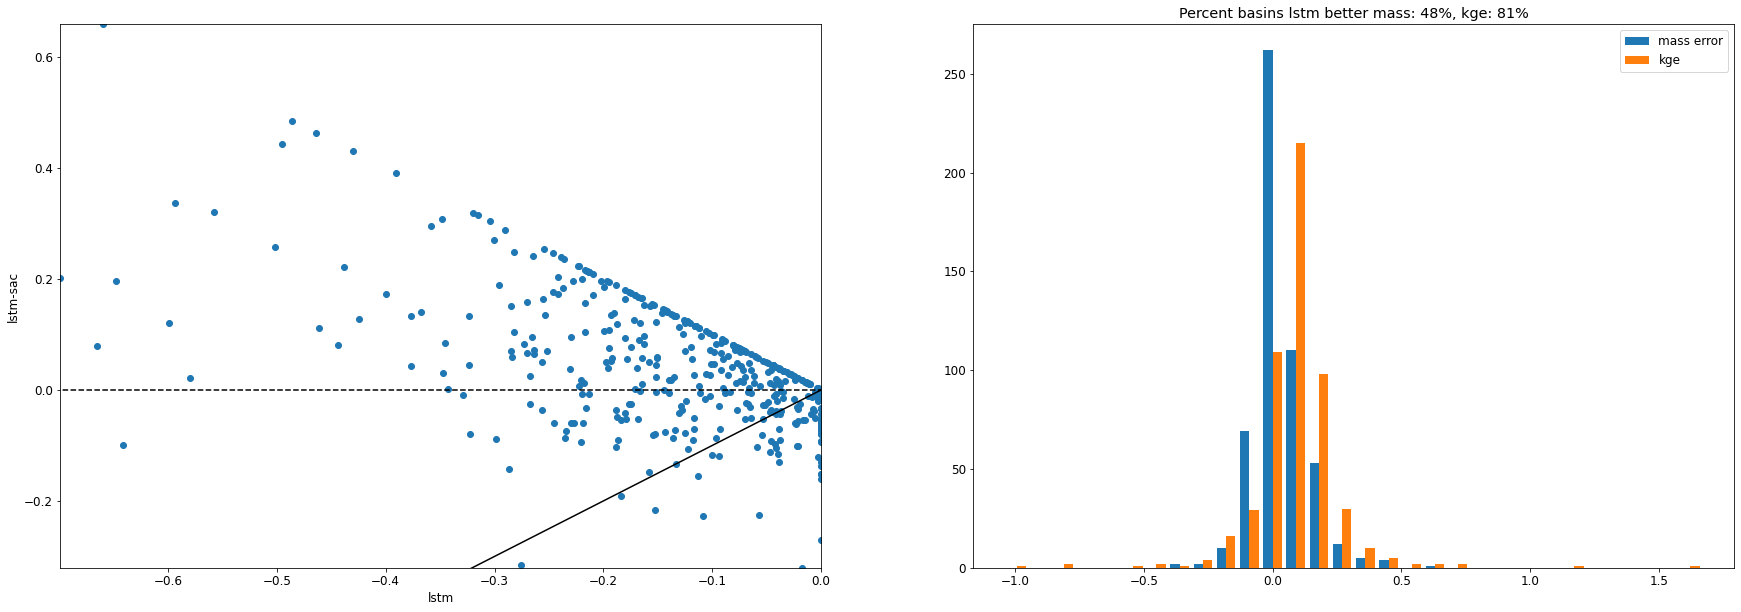

FORCING:  nldas
MASS ERROR TYPE:  negative
MODEL PAIR mc-sac


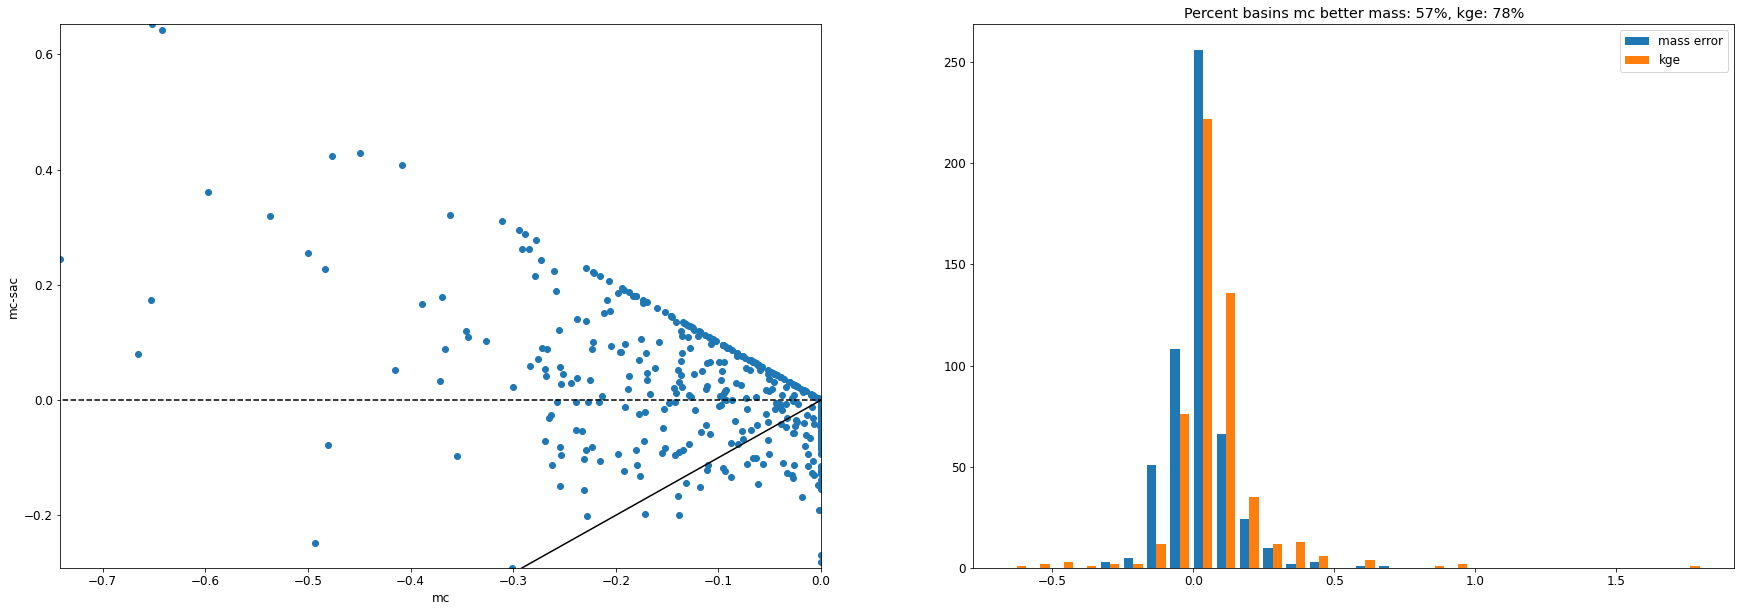

FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-mc


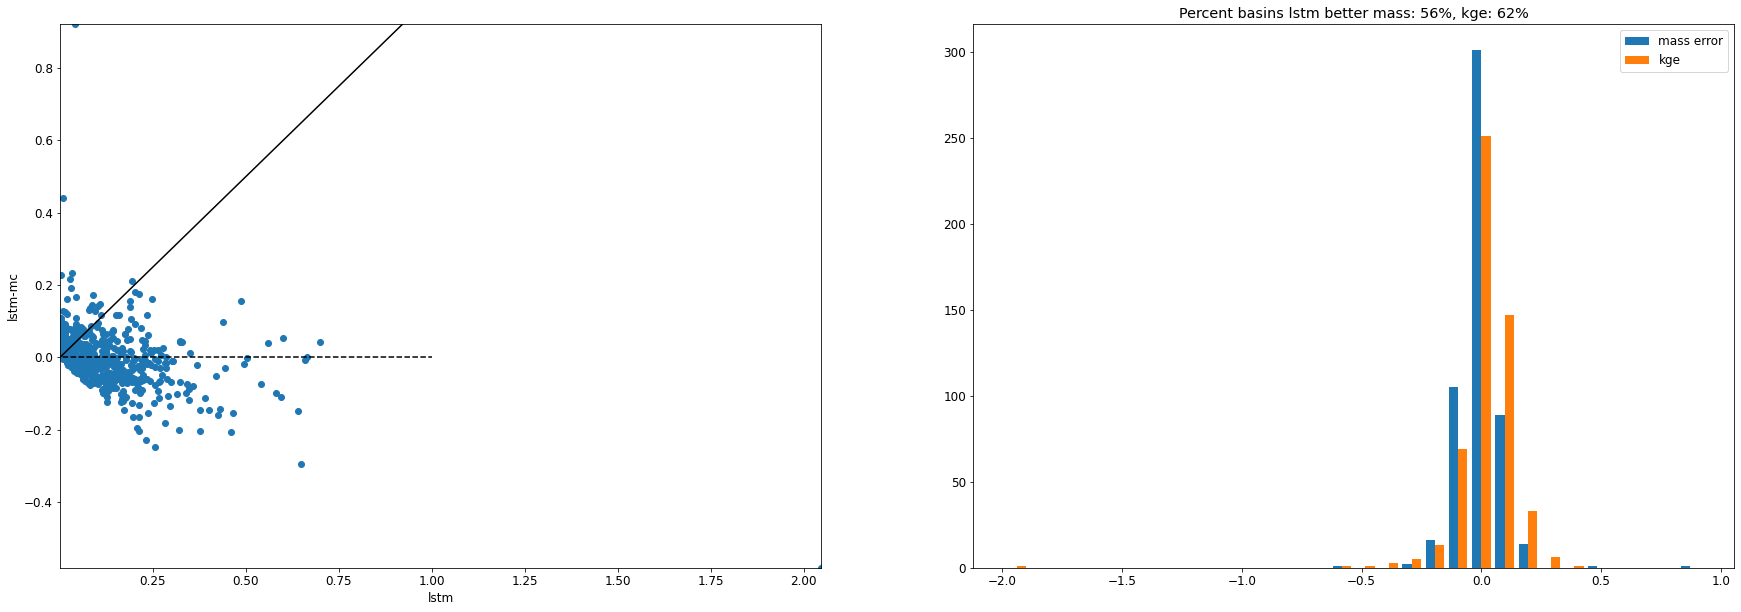

FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-sac


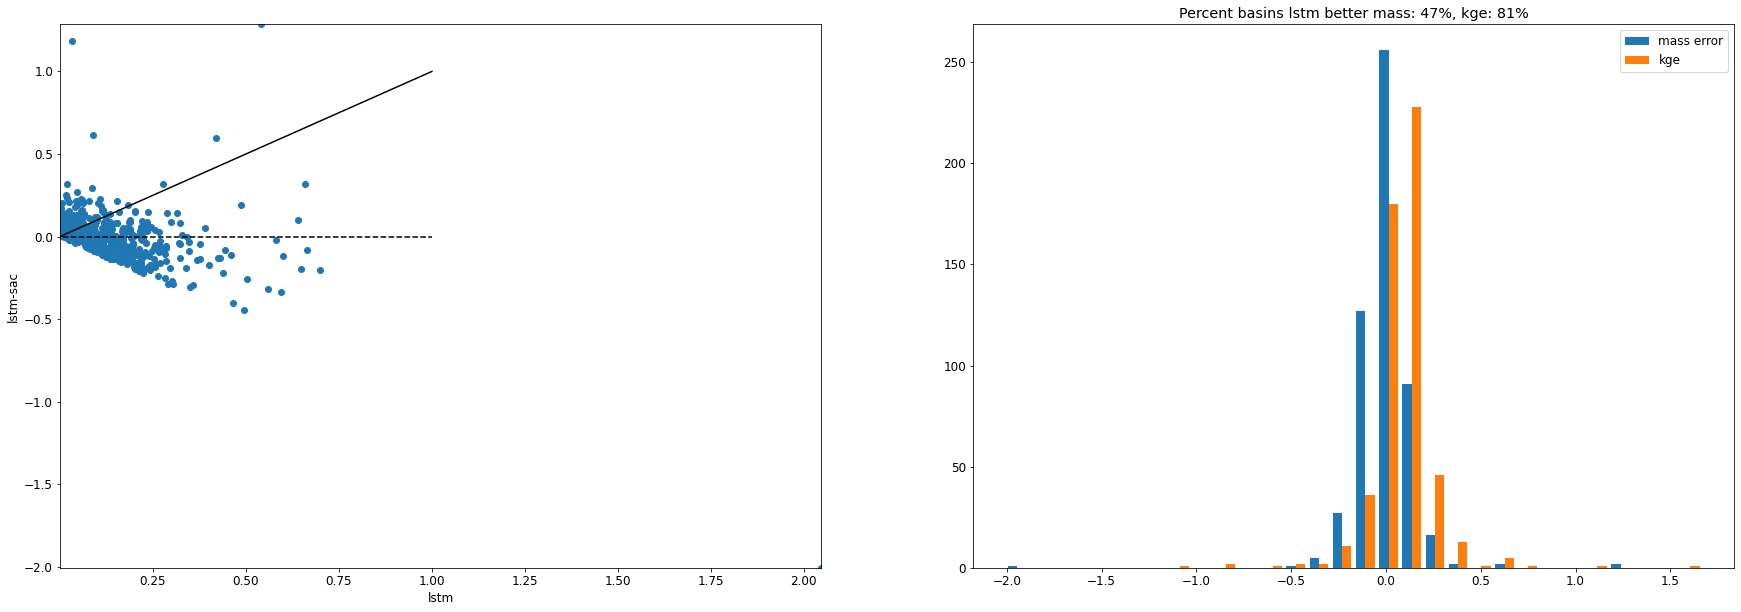

FORCING:  nldas
MASS ERROR TYPE:  absolute
MODEL PAIR mc-sac


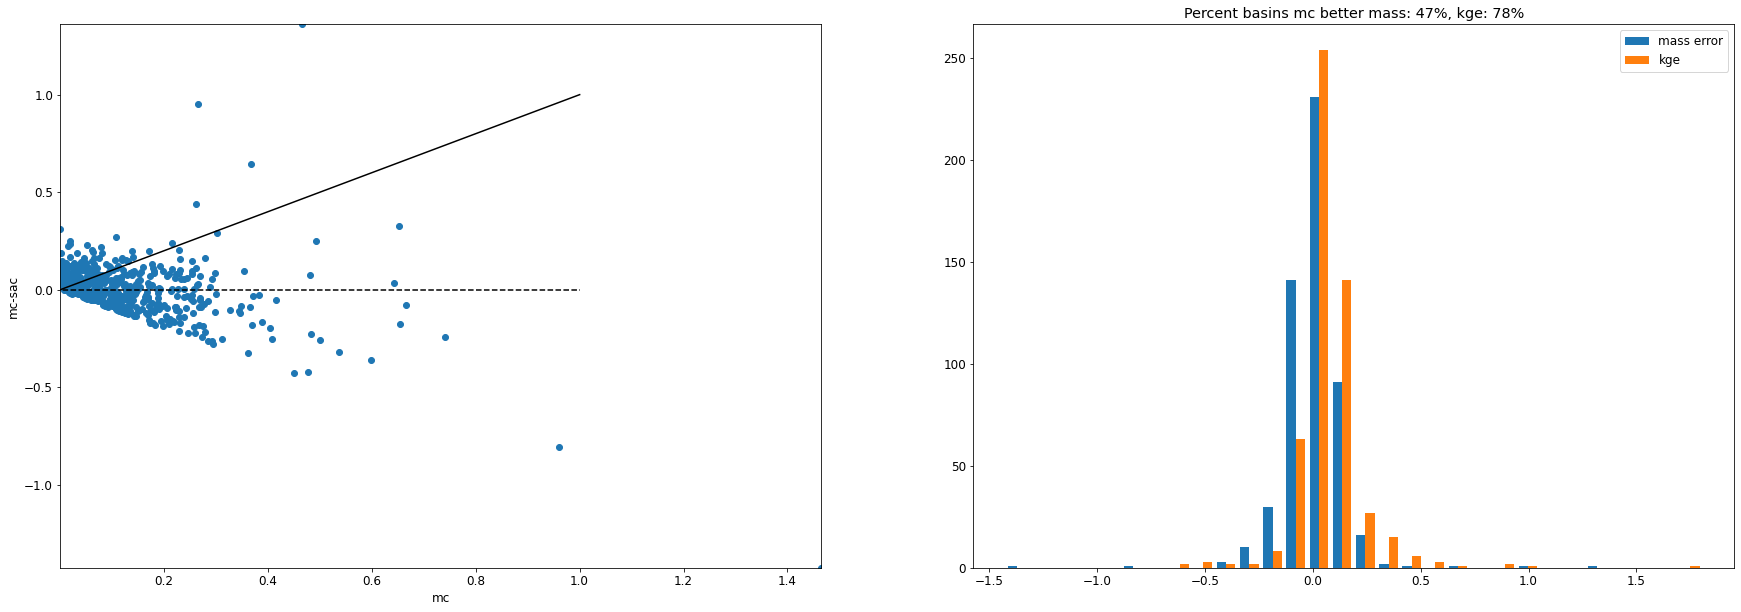

FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR lstm-mc


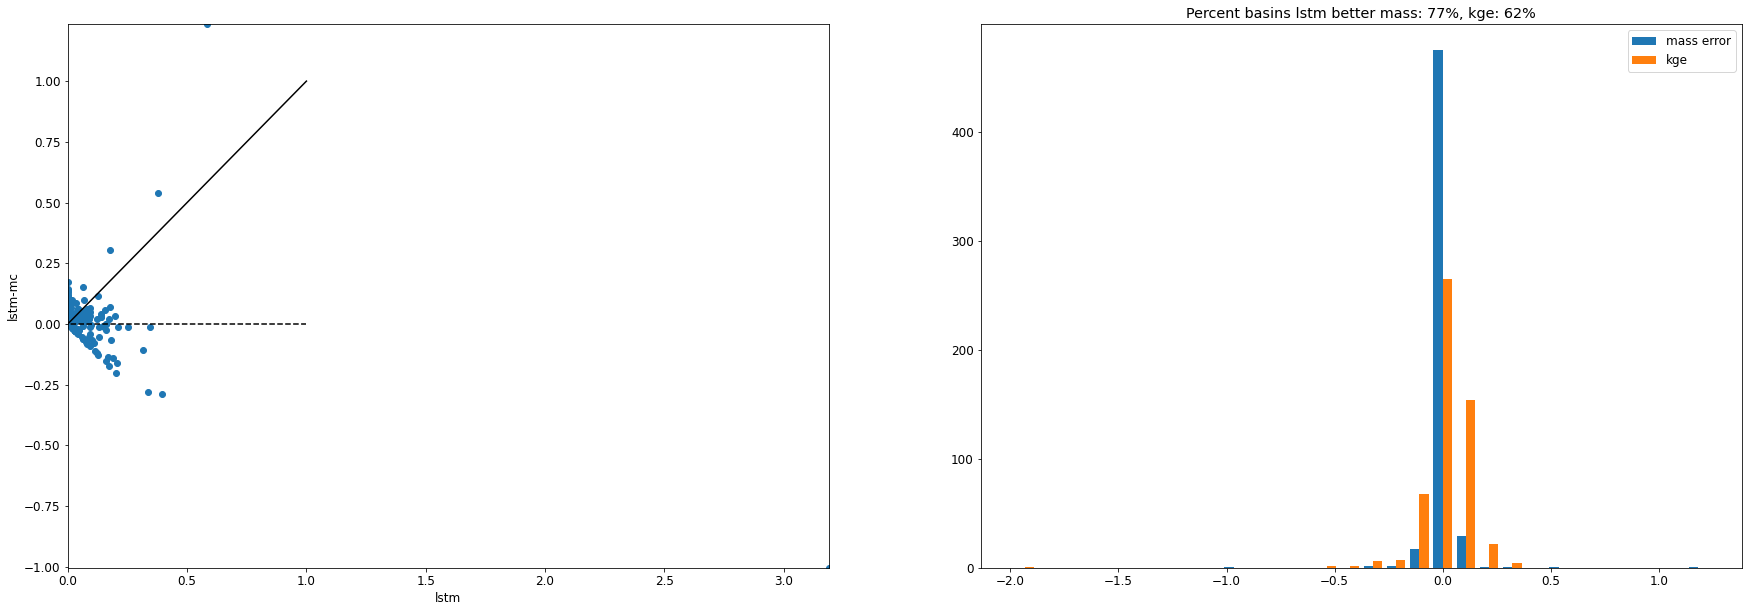

FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR lstm-sac


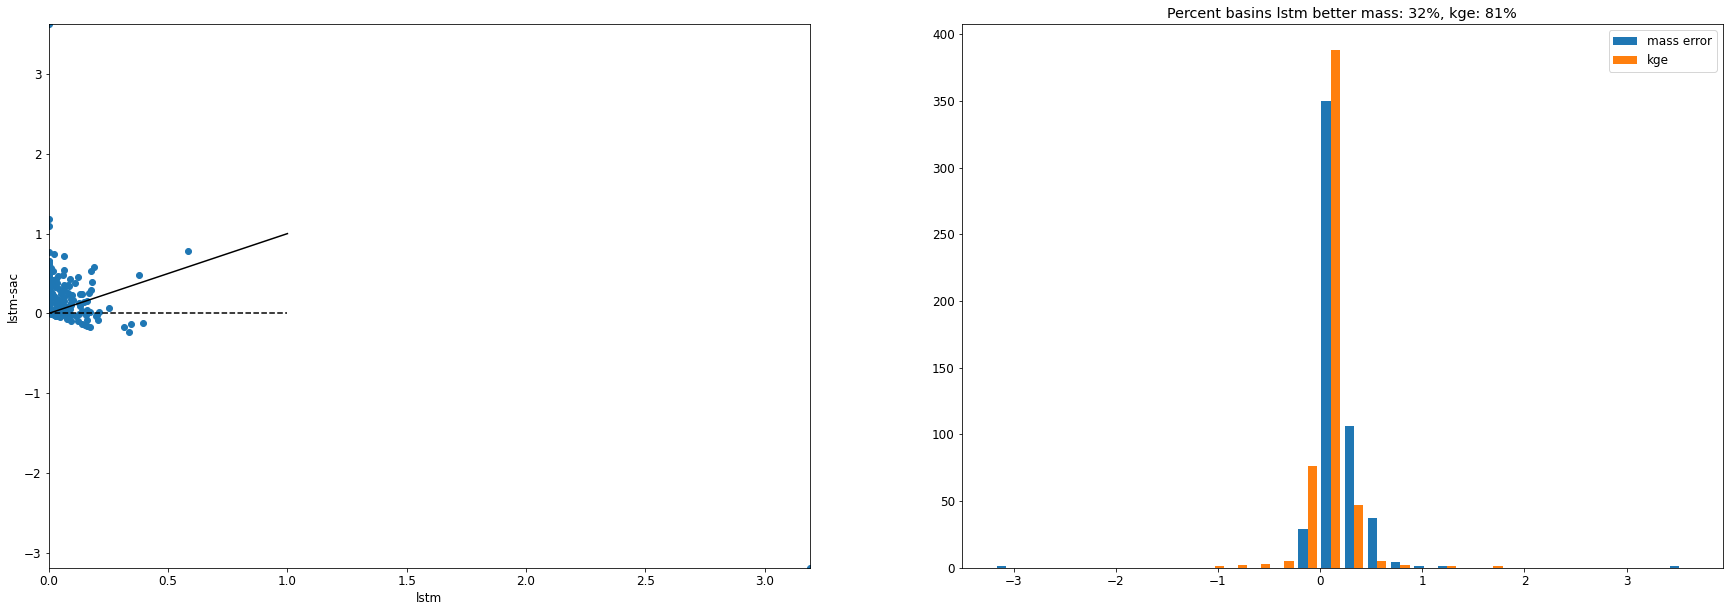

FORCING:  daymet
MASS ERROR TYPE:  positive
MODEL PAIR mc-sac


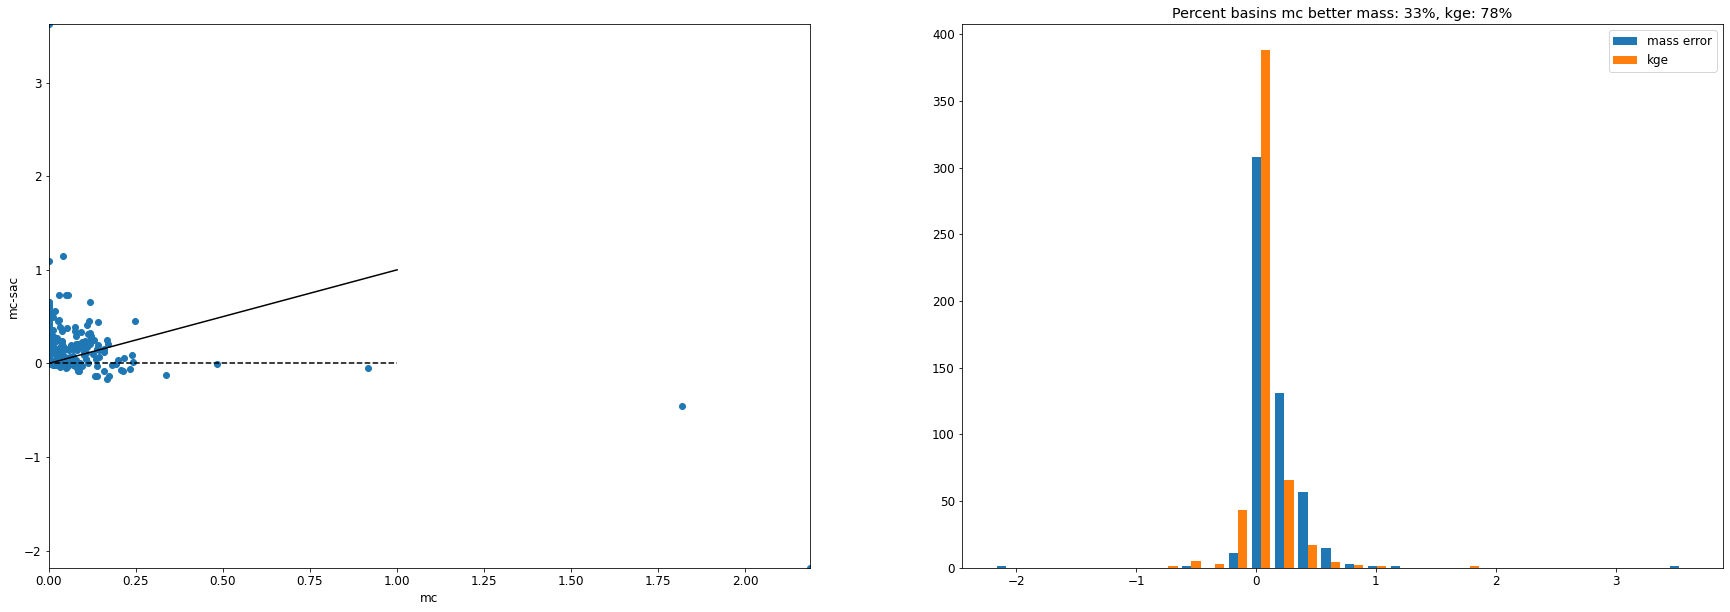

FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR lstm-mc


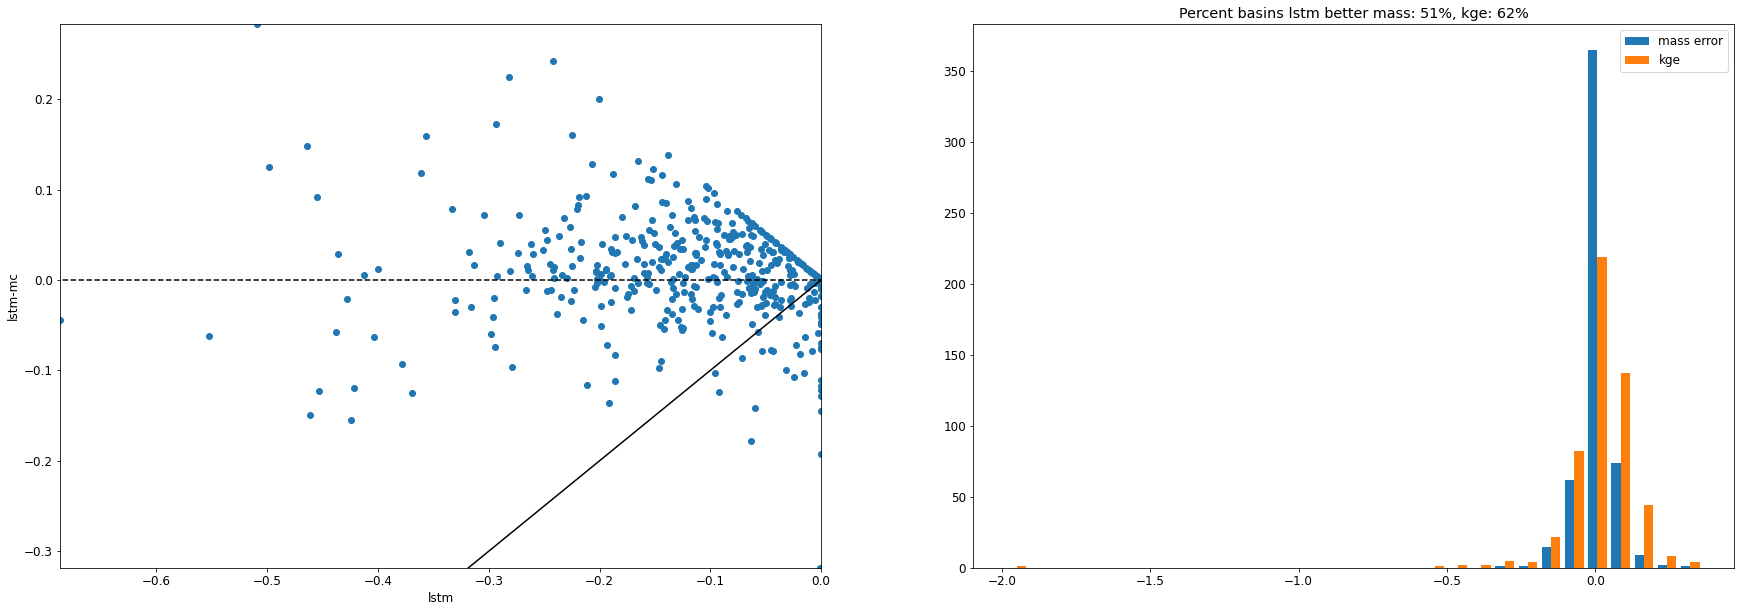

FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR lstm-sac


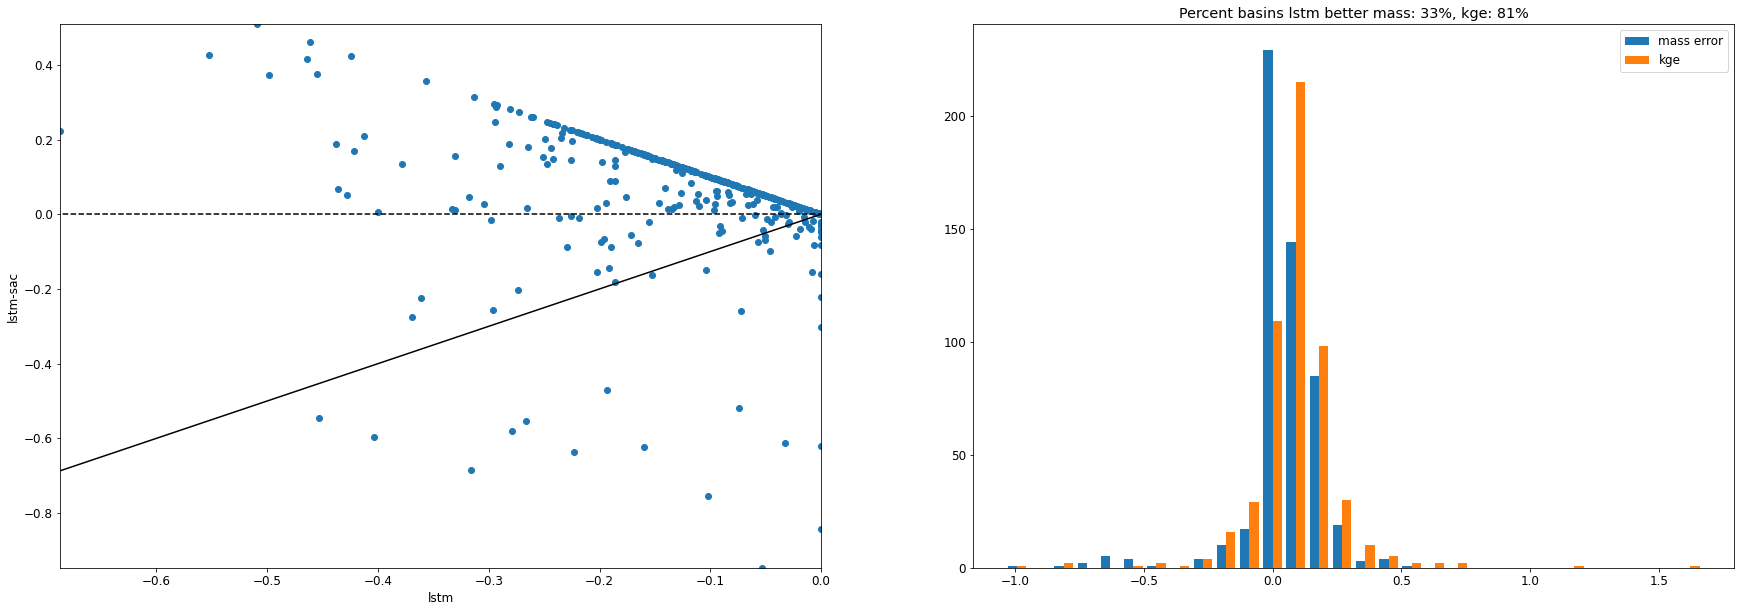

FORCING:  daymet
MASS ERROR TYPE:  negative
MODEL PAIR mc-sac


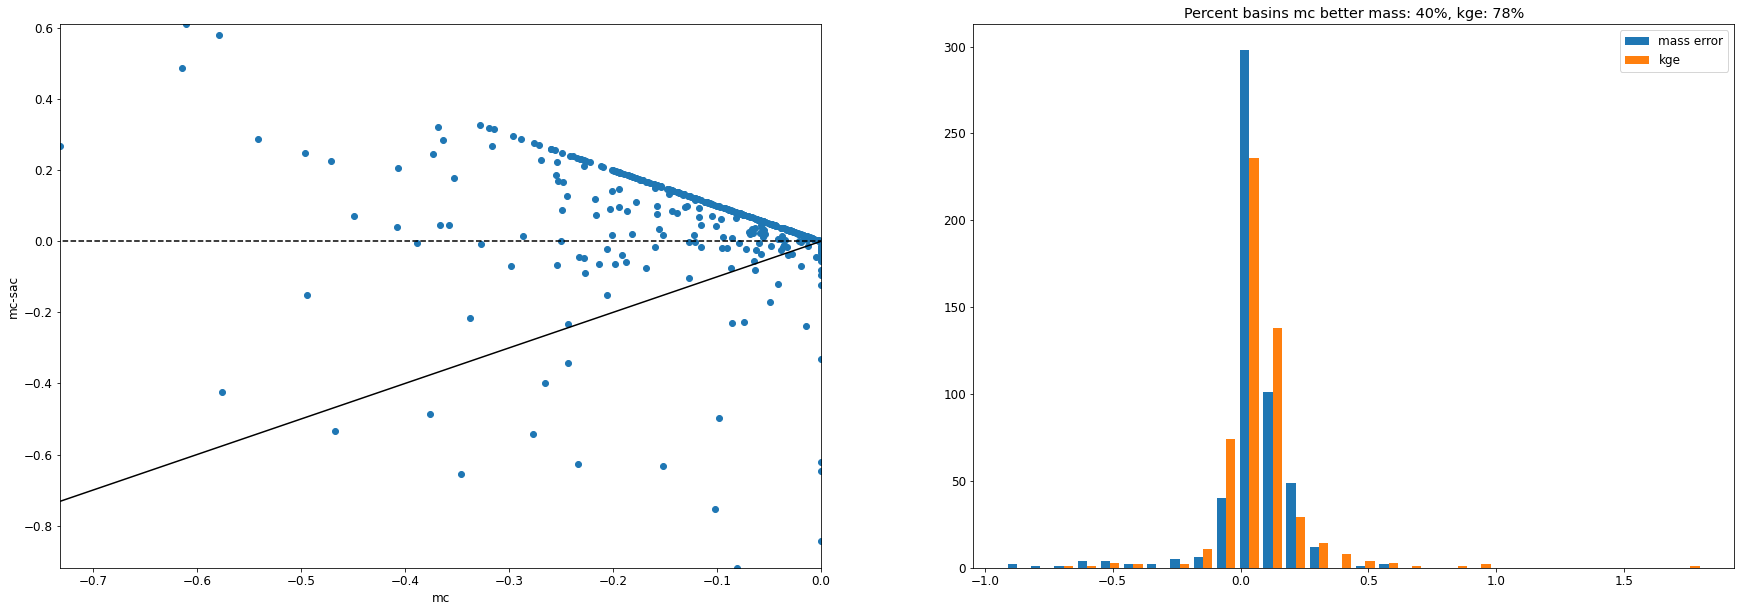

FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-mc


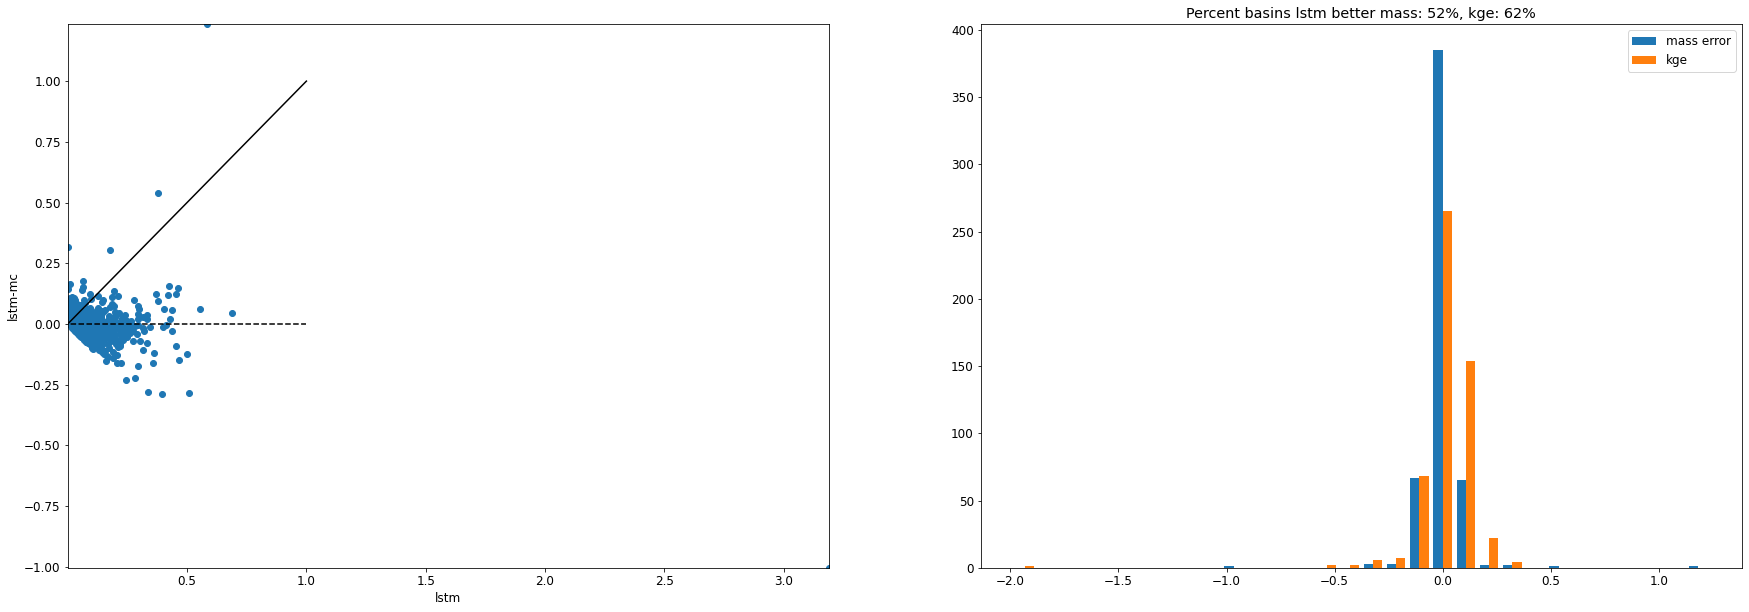

FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR lstm-sac


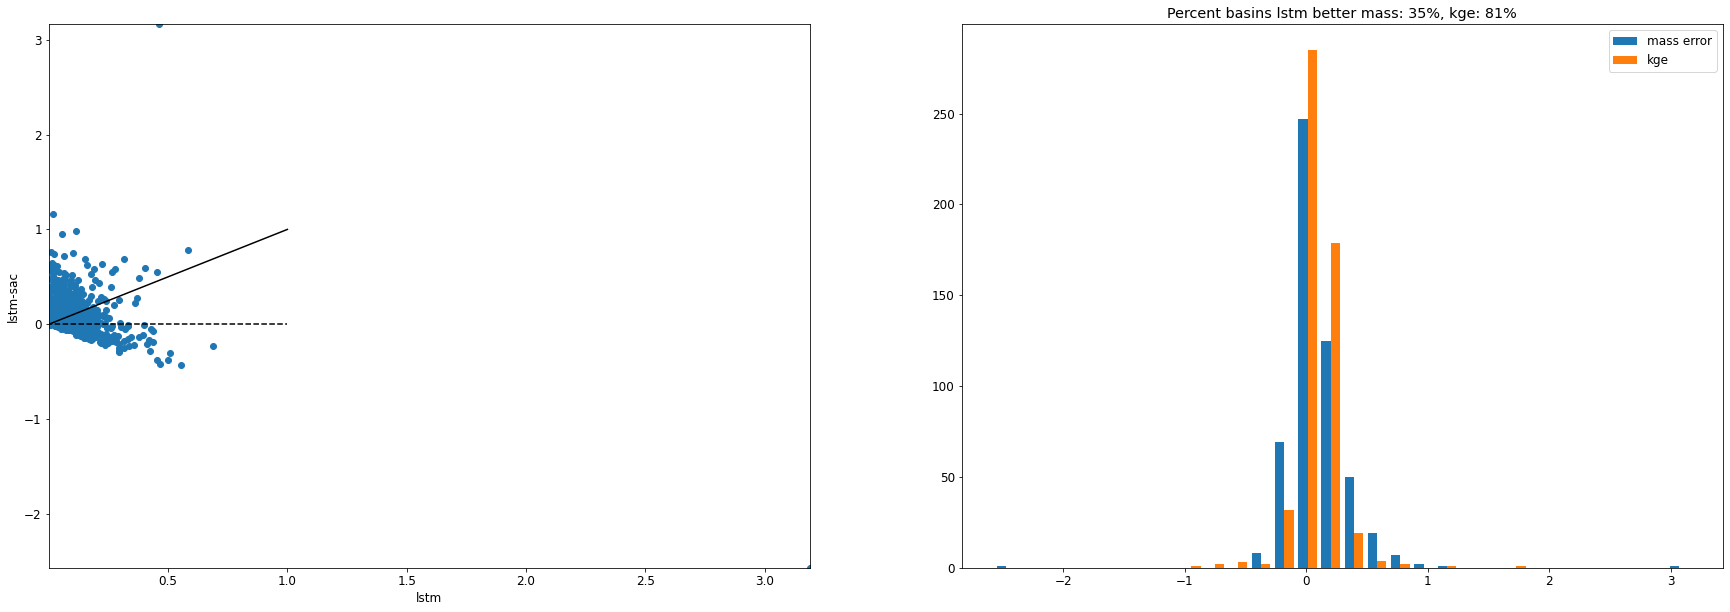

FORCING:  daymet
MASS ERROR TYPE:  absolute
MODEL PAIR mc-sac


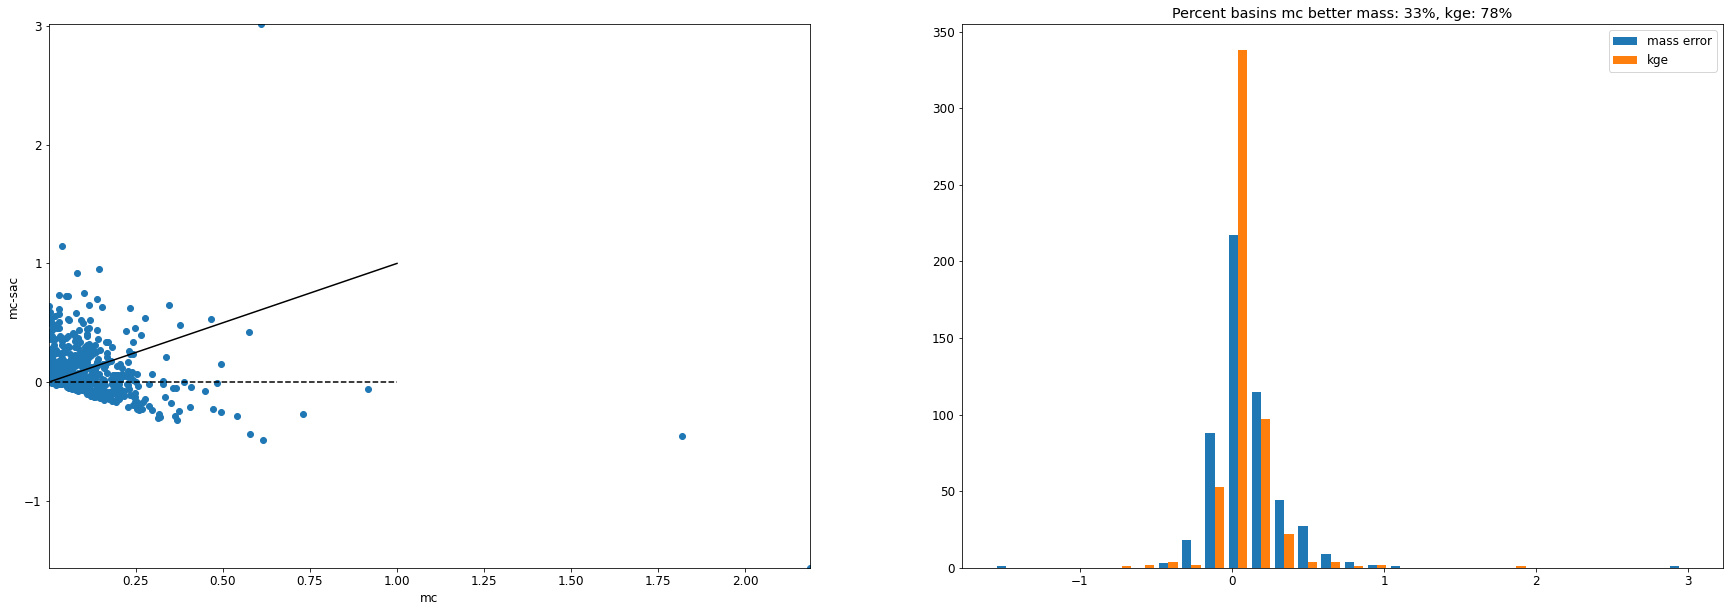

In [147]:
for forcing in ["nldas", "daymet"]:
    
    for err_type in ['positive', 'negative', 'absolute']:

        for model_pair in [["lstm", "mc"], ["lstm", "sac"], ["mc", "sac"]]:
            
            print("FORCING: ", forcing)
            print("MASS ERROR TYPE: ", err_type)
            model_diff_name = str(model_pair[0])+'-'+str(model_pair[1])
            print("MODEL PAIR", model_diff_name)

            x = np.array(total_mass_error[forcing]["time_split1"][err_type][model_pair[0]])
            y = np.array(total_mass_error[forcing]["time_split1"][err_type][model_pair[1]]) - \
                np.array(total_mass_error[forcing]["time_split1"][err_type][model_pair[0]])
                
            xlims = [np.min(x), np.max(x)]
            ylims = [np.min(y), np.max(y)]
            
            #----------------------------------------#
            fig = plt.figure(figsize=(30,10))
            
            
            ax = fig.add_subplot(1, 2, 1)
            ax.scatter(x,y)
            ax.set_xlabel(model_pair[0])
            ax.set_ylabel(model_diff_name)
            ax.plot([1,-1], [1,-1], c="k")
            ax.plot([-1,1], [0,0], '--', c="k")
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            
            ax = fig.add_subplot(1, 2, 2)

            y_kge = np.array(st2_dict[forcing_type]["KGE"][model_pair[0]]) - \
                np.array(st2_dict[forcing_type]["KGE"][model_pair[1]])            
            ax.hist([y,y_kge],bins=30, label=["mass error", "kge"])
            
            perc_lstm_better_mass = int(100-np.round(100*y[y>0].shape[0] / y.shape[0],1))
            perc_lstm_better_kge = int(np.round(100*y_kge[y_kge>0].shape[0] / y_kge.shape[0],1))
            
            ax.set_title(f"Percent basins {model_pair[0]} better mass: {perc_lstm_better_mass}%, kge: {perc_lstm_better_kge}%")
            plt.legend()
            
            plt.show()
            plt.close()

In [57]:
y_kge[y_kge>0].shape[0]

418